<a href="https://colab.research.google.com/github/chase-urasaki/HyTI_Jitter_Metrology/blob/main/Jitter_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Here is a walk through / refactored notebook of the code that was written for my Master's thesis on the optical metrology system. This notebook is used mainly as a tutorial on how to analyze the data to obtain the data products described. It is meant to be as "plug and play" as possilbe defining functions that will just take in arguements as file names. Other than just, just follow the code, replacing variable names and local files with your own. Please feel free to contact me (chasemu@hawaii.edu) if you have any questions/comments/issues! To actually take data, see the other python codes in the folder. Note that the code is not *perfectly* optimized. There are a lot of things that could still be converted to functions that I just didn't have time to do. Feel free to make changes and submit a pull request!

Change log:


*   4/11/2024 - Created; imported from 3/12 data analysis notebook
*   4/25/2024 - Updated & Added Configuration 1 Code.
*   5/21/2024 - Added Configuration 2 Code.
*   5/23/2024 - Added Configuration 3 & Configuration 4 Code



# Data Loading
Note that this might be different if you are running this locally, but if you have a drive directory with the data, then you will need to change it to point there. all the data files are in the GitHub.

In [4]:
#Mount Google drive
from google.colab import drive

drive.mount('/content/drive');

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


In [5]:
import os

In [6]:
cd drive/MyDrive/'Jitter Metrology'/Final_code_and_data/data

/content/drive/.shortcut-targets-by-id/1oOTCuLadXNs0Gh6zZHhxR42ClxA_yakd/Jitter Metrology/Final_code_and_data/data


In [7]:
#Import essentials
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib import ticker
import scipy.signal as sp
import sys
import pandas as pd
import csv
from scipy.optimize import curve_fit
import scipy.integrate
from numpy.ma.extras import median

In [8]:
# define some helper functions
def seperate_data_from(data_array):
    """
    "pulls data from csv file into the x direction, y direction, v sum, and time

      Parameters
      ----------
      data_array: array_like
                  Data array brought in from something like numpy genfromtxt
    """
    xdata = data_array[:,-2]
    ydata = data_array[:,-1]
    vsum_data = data_array[:,-3]
    tdata = data_array[:,1]
    return xdata, ydata, vsum_data, tdata

def data_as_df(data_array):
     df = pd.DataFrame(data_array)
     return df

def one_sided_fft(t,x):
    full_amplitude_spectrum = np.abs(np.fft.fft(x))/x.size
    full_freqs = np.fft.fftfreq(x.size, np.mean(np.ediff1d(t)))
    oneinds = np.where(full_freqs >=0.0)
    one_sided_freqs = full_freqs[oneinds]
    one_sided_amplitude_spectrum=2*full_amplitude_spectrum[oneinds]
    return one_sided_freqs, one_sided_amplitude_spectrum

def power_spectrum(t,x):
    onef, oneamps = one_sided_fft(t,x)
    return onef, oneamps**2

def rad_to_arcsec(radians):
  """ quick function to convert radians to arcsecs"""
  arcsecs = radians * 206264.806
  return arcsecs

def lomb_scargle_pspec(t, x):
    tstep = np.mean(np.ediff1d(t))
    freqs = np.fft.fftfreq(x.size, tstep)
    idxx = np.argsort(freqs)
    one_sided_freqs = freqs[idxx]
    one_sided_freqs = one_sided_freqs[one_sided_freqs>0]
    #KLUDGE TO KEEP PERIODOGRAM FROM CRASHING
    one_sided_freqs = one_sided_freqs+0.00001*np.random.random(one_sided_freqs.size)
    #THE FOLLOWING LINE CRASHES WITHOUT THE KLUDGE
    pgram = sp.lombscargle(t, x, one_sided_freqs*2*np.pi)
    return one_sided_freqs, (pgram/(t.size/4))

def lorentzianoffset(x, x0, A, gamma, y0):
  """ Lorentzian function centered at x0 with the amplitude A and FWHM gamma"""
  return y0 + (A *gamma**2 / (gamma**2 + (x-x0)**2))

In [9]:
def plot_PSD_and_pos(tdata, xdata, ydata, xpsc, ypsc, plot_title):
  """
  Plots the PSD and time series of the data for visualization purposes

  Parameters
  -----------
  tdata: array_like
        Time data
  xdata: array_like
        x position data
  ydata: array_like
  xpsc: array_like -


  """
  fig_x, (ax1, ax2) = plt.subplots(2,1, figsize =(15,7))
  fig_x.suptitle(str(plot_title)+' (x - dir)')
  fig_x.tight_layout(h_pad = 4.5)
  ax1.plot(xpsc[0], xpsc[1])
  ax1.set_title('PSD')
  ax1.set_xlabel('Frequency [Hz]')
  ax1.set_ylabel(r'Spectral Density [V$^2$/Hz]')
  ax1.tick_params(axis='both', which = 'major', labelsize=11)
  ax1.tick_params(axis='both', which = 'minor', labelsize=11)
  ax2.scatter(tdata, (xdata - np.mean(xdata)) * 1e6, alpha = 0.5)
  ax2.set_title('Position on Sensor',fontsize=18)
  ax2.set_xlabel('Time [s]', fontsize=18)
  ax2.set_ylabel(r'Position [$\mu$m]', fontsize=18)
  ax2.tick_params(axis='both', which = 'major', labelsize=18)
  ax2.tick_params(axis='both', which = 'minor', labelsize=18)

  fig_y, (ax3, ax4) = plt.subplots(2,1, figsize = (15,7))
  fig_y.suptitle(str(plot_title) + ' (y - dir)')
  fig_y.tight_layout(h_pad = 4.5)
  ax3.plot(ypsc[0], ypsc[1], c = 'C1')
  ax3.set_title('FFT')
  ax3.set_xlabel('Frequency [Hz]')
  ax3.set_ylabel(r'Spectral Density [V$^2$/Hz]')
  ax4.scatter(tdata, (ydata - np.mean(ydata)) * 1e6, marker = '.', alpha = 0.5, c = 'C1')
  ax4.set_title('Position on Sensor')
  ax4.set_xlabel('Time [s]')
  ax4.set_ylabel(r'Position [$\mu$m]')

  return fig_x, fig_y

In [10]:
def plot_PSD_and_pos_angular(tdata, xdisp, ydisp, xpsc_arcsec, ypsc_arcsec, plot_title):
  fig_x, (ax1, ax2) = plt.subplots(2,1, figsize =(15,7))
  fig_x.suptitle(str(plot_title)+' (x - dir)')
  fig_x.tight_layout(h_pad = 4.5)
  ax1.plot(xpsc_arcsec[0], xpsc_arcsec[1])
  ax1.set_title('PSD')
  ax1.set_xlabel('Frequency [Hz]')
  ax1.set_ylabel(r'Spectral Density [arcsec$^2$/Hz]')
  ax1.set_ylim(1e-8,10*max(xpsc_arcsec[1]))
  ax1.set_yscale('log')
  ax1.tick_params(axis='both', which = 'major', labelsize=11)
  ax1.tick_params(axis='both', which = 'minor', labelsize=11)
  ax2.scatter(tdata, xdisp, alpha = 0.5)
  ax2.set_title('Angular Displacement on Sensor')
  ax2.set_xlabel('Time [s]')
  ax2.set_ylabel(r'Displacement [arcsec]')

  fig_y, (ax3, ax4) = plt.subplots(2,1, figsize = (15,7))
  fig_y.suptitle(str(plot_title) + ' (y - dir)')
  fig_y.tight_layout(h_pad = 4.5)
  ax3.plot(ypsc_arcsec[0], ypsc_arcsec[1], c = 'C1')
  ax3.set_title('FFT')
  ax3.set_xlabel('Frequency [Hz]')
  ax3.set_ylabel(r'Spectral Density [arcsec$^2$/Hz]')
  ax3.set_ylim(1e-8,10*max(ypsc_arcsec[1]))
  ax3.set_yscale('log')
  ax4.scatter(tdata, ydisp, marker = '.', alpha = 0.5, c = 'C1')
  ax4.set_title('Angular Displacement on Sensor')
  ax4.set_xlabel('Time [s]')
  ax4.set_ylabel(r'Displacement [arcsec]')

  return fig_x, fig_y

In [11]:
def zoom_in_on(psc, freq_vals, delta_freq, plot_color):
  """ quick function to zoom in on a certain portion of the power spectrum for analysis

  """
  if len(freq_vals) > 1.5:
    fig, axis = plt.subplots(1,len(freq_vals), sharey = True, figsize = (5*len(freq_vals),5))
    axis = axis.flatten()
    for idx, freq in enumerate(freq_vals):
      axis[idx].plot(psc[0],psc[1], c = str(plot_color))
      axis[idx].set_xlim((freq - delta_freq), (freq + delta_freq))

  else:
    fig, axis = plt.subplots()
    axis.plot(psc[0], psc[1], c = str(plot_color))
    axis.set_xlim((freq_vals[0] - delta_freq), (freq_vals[0] + delta_freq))

  plt.show()
  plt.close()

In [12]:
def write_array_to_csv(array, filename):
  """ Function to write the results of the lorentzian fit to a csv file. With no path specified, it writes it to the same directory that is being worked in.

  Parameters:
  -----------
  """
  headers = ['Peak Center [Hz]', 'Peak Amplitude [arcsec^2/Hz]', 'FWHM [Hz]', 'offset', 'Center Variance', 'Peak Variance', 'FWHM Variance', 'Offset Variance', 'Pointing rms [arcsec]', 'Poitning rms - Error [arcsec]']
  with open(filename, 'w', newline = '') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(array)

In [13]:
def keep_peaks_from(indicies_list, result_array, array_name):
  """ filters out peaks that user wishes to keep and writes them to csv file with the headers
  as described in the write array to csv function """

  final_array = np.zeros((len(indicies_list), 8))

  for i in range(len(indicies_list)):
    final_array[i,:] = result_array[indicies_list[i], :]

  write_array_to_csv(final_array, array_name)


  return final_array

In [14]:
def plot_peaks(peaks_to_plot, freqs, original_psd, original_psd_err, plot_title, dir):

  """ Function to plot the peaks that were fit on 1) the whole psd and 2) showing the goodness-of-fits
  for each peak that was found"""

  if dir == 'x':
    point_fmt = 'C0.'
  elif dir == 'y':
    point_fmt = 'C1.'
  plt.close()

  fig, ax = plt.subplots(figsize = (12,5))
  ax.errorbar(freqs, original_psd, yerr= original_psd_err, fmt = point_fmt, ecolor = 'red', elinewidth = 0.75, zorder = 0)
  ax.set_ylim(1e-12,10*max(original_psd))
  ax.set_yscale('log')
  ax.scatter(peaks_to_plot[:,0], peaks_to_plot[:,1], marker = 'x', color = 'k', zorder = 1)
  for index in range(len(peaks_to_plot[:,0])):
    ax.text(peaks_to_plot[index,0], 5*peaks_to_plot[index,1], "{:.2f}".format(peaks_to_plot[index,0]), fontsize = 12, color = 'k')
  ax.set_title(str(plot_title))
  ax.set_xlabel('Frequency [Hz]', fontsize=18)
  ax.set_ylabel('Spectral Density [arcsec^2 / Hz]',fontsize=18)
  ax.tick_params(axis='both', which='major', labelsize=18)
  ax.tick_params(axis='both', which='minor', labelsize=18)
  plt.show(fig)

  for freq_index in range(np.size(peaks_to_plot, axis = 0)):
    freqs_to_plot = np.linspace(peaks_to_plot[freq_index,0]-3, peaks_to_plot[freq_index,0]+3,100)
    y_fit = lorentzianoffset(freqs_to_plot, peaks_to_plot[freq_index, 0], peaks_to_plot[freq_index, 1], peaks_to_plot[freq_index,2], peaks_to_plot[freq_index,3])
    plt.xlim(freqs_to_plot[0], freqs_to_plot[-1])
    plt.xlabel('Frequency [Hz]')
    plt.ylim(0.1*min(y_fit),10*max(y_fit))
    plt.yscale("log")
    plt.ylabel('Spectral Density [arcsec^2/Hz]')
    plt.title('[{index}] Peak at {peak_freq:.1f} Hz'.format(index = freq_index, peak_freq = peaks_to_plot[freq_index,0]))
    plt.errorbar(freqs, original_psd, yerr=original_psd_err, fmt = point_fmt, ecolor = 'red', elinewidth = 0.75, zorder = 0)
    plt.plot(freqs_to_plot, y_fit, 'k--')
    plt.show()

In [15]:
def do_science_with_offset(freq_range, psd_values, psd_error, plot_it, dir, prom, thresh):
    """
    Identify peaks in the Power Spectral Density (PSD) data, fit a Lorentzian function to each peak,
    and optionally plot the results.

    Parameters:
    freq_range (array-like): Frequency range of the PSD data.
    psd_values (array-like): PSD values.
    psd_error (array-like): Errors in the PSD values.
    plot_it (bool): Whether to plot the results.
    dir (str): Direction indicator for plotting.
    prom (float): Prominence threshold for peak detection.
    thresh (float): Threshold for peak detection.

    Returns:
    np.ndarray: Array of fitted peak parameters and their errors.
    """
    fit_margin = 6

    peaks_list,_ = scipy.signal.find_peaks(psd_values, prominence = float(prom), threshold = float(thresh), distance = 900) #5 Hz
    peak_amps = np.asarray(psd_values)[peaks_list]
    peak_freqs = np.asarray(freq_range)[peaks_list].flatten()

    # make empty array with size: # of peaks (rows) and 8 variables (columns)
    results_array = np.zeros((len(peaks_list), 8))

    # for each peak, do fit
    for i in range(len(peak_freqs)):
      center_freq = peak_freqs[i]
      amp = peak_amps[i]
      #select appropiate range of data:
      applicable_range = freq_range[(freq_range[0] >= (center_freq - fit_margin)) & (freq_range[0] <=(center_freq + fit_margin))].index.values

      freqs_lower_idx, freqs_upper_idx = applicable_range[0], applicable_range[-1]

      freqs = np.asarray(freq_range.loc[freqs_lower_idx:freqs_upper_idx]).flatten()

      values_to_fit = np.asarray(psd_values.loc[freqs_lower_idx:freqs_upper_idx])
      y_offset = median(values_to_fit)

      valueerrs_to_fit = np.asarray(psd_error.loc[freqs_lower_idx:freqs_upper_idx])

      p0 = center_freq, amp, 0.1, y_offset

      max_its = 500
      converged = False

      for iteration in range(max_its):
        try:
          popt, pcov  = curve_fit(lorentzianoffset, freqs, values_to_fit, p0)
          yfit = lorentzianoffset(freqs, *popt)

          if np.all(popt != np.inf):
            converged = True
            break
        except RuntimeError:
          pass
      if converged:
        #center, amp, fwhm, variance center, variance amp, variance fwhm
        results_array[i] = *popt, *np.diag(pcov)

      else:
        continue

    def filter_array(result_array):
    #Remove any points that are all 0's - this means the fit didn't converge
      cleaned_array = result_array[result_array[:,0] > 0]

      #remove any points that are greater than 500 Hz
      cleaned_array = cleaned_array[cleaned_array[:,0]< 500]
      cleaned_array = cleaned_array[cleaned_array[:,1]> 0]

      return(cleaned_array)

    results_array = filter_array(results_array)

    if plot_it == True:

      if dir == 'x':
        point_fmt = 'C0.'
      elif dir == 'y':
        point_fmt = 'C1.'

    fig, ax = plt.subplots(figsize = (12,5))
    ax.errorbar(freq_range, psd_values, yerr= psd_error, fmt = point_fmt, ecolor = 'red', elinewidth = 0.75, zorder = 0)
    ax.set_ylim(1e-12,5*max(psd_values))
    ax.set_yscale('log', nonpositive = 'clip')
    ax.scatter(results_array[:,0], results_array[:,1], marker = 'x', color = 'k', zorder = 1)
    for index in range(len(results_array[:,0])):
      ax.text(results_array[index,0], results_array[index,1], str(index), fontsize = 8, color = 'k')
    ax.set_title('Found peaks in {}- direction'.format(dir))
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Spectral Density [arcsec^2 / Hz]')

    return results_array


# Configuration 1

This configuration is for the air bearing off, payload and cryocooler off, and ADCS off. The data here is representative of the ambient vibrations going on in the cleanroom due to *mostly seismic* activity.

In [17]:
# Calculate the throw distance, or the distance that the deflection of the mirror acts over. This is the total distance from the mirror to LEPS (in meters)
throw_distance = 98.3e-2+232.59e-3+51.6e-3+3.05e-3
throw_distance

1.27024

In [ ]:
# Read in the data from the first trial
bearingoff_electronicsoff_1 = np.genfromtxt('data_3_13_bearingoff_electronicsoff_1in_20230313-162724.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicsoff_1_xdata, bearingoff_electronicsoff_1_ydata, bearingoff_electronicsoff_1_vsum, bearingoff_electronicsoff_1_tdata = seperate_data_from(bearingoff_electronicsoff_1)
bearingoff_electronicsoff_1_xdisp = rad_to_arcsec(((bearingoff_electronicsoff_1_xdata) - np.mean(bearingoff_electronicsoff_1_xdata)) / throw_distance)
bearingoff_electronicsoff_1_ydisp = rad_to_arcsec(((bearingoff_electronicsoff_1_ydata) - np.mean(bearingoff_electronicsoff_1_ydata)) / throw_distance)
bearingoff_electronicsoff_1_xpsc_arcsec = power_spectrum(bearingoff_electronicsoff_1_tdata, bearingoff_electronicsoff_1_xdisp)
bearingoff_electronicsoff_1_ypsc_arcsec = power_spectrum(bearingoff_electronicsoff_1_tdata, bearingoff_electronicsoff_1_ydisp)

In [ ]:
# Read in data from second trial
bearingoff_electronicsoff_3 = np.genfromtxt('data_3_13_bearingoff_electronicsoff_3in_20230313-163728.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicsoff_3_xdata, bearingoff_electronicsoff_3_ydata, bearingoff_electronicsoff_3_vsum, bearingoff_electronicsoff_3_tdata = seperate_data_from(bearingoff_electronicsoff_3)
bearingoff_electronicsoff_3_xdisp = rad_to_arcsec(((bearingoff_electronicsoff_3_xdata) - np.mean(bearingoff_electronicsoff_3_xdata)) / throw_distance)
bearingoff_electronicsoff_3_ydisp = rad_to_arcsec(((bearingoff_electronicsoff_3_ydata) - np.mean(bearingoff_electronicsoff_3_ydata)) / throw_distance)
bearingoff_electronicsoff_3_xpsc_arcsec = power_spectrum(bearingoff_electronicsoff_3_tdata, bearingoff_electronicsoff_3_xdisp)
bearingoff_electronicsoff_3_ypsc_arcsec = power_spectrum(bearingoff_electronicsoff_3_tdata, bearingoff_electronicsoff_3_ydisp)

In [ ]:
# Read in data from third trial
bearingoff_electronicsoff_4 = np.genfromtxt('data_3_13_bearingoff_electronicsoff_4in_20230313-164202.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicsoff_4_xdata, bearingoff_electronicsoff_4_ydata, bearingoff_electronicsoff_4_vsum, bearingoff_electronicsoff_4_tdata = seperate_data_from(bearingoff_electronicsoff_4)
bearingoff_electronicsoff_4_xdisp = rad_to_arcsec(((bearingoff_electronicsoff_4_xdata) - np.mean(bearingoff_electronicsoff_4_xdata)) / throw_distance)
bearingoff_electronicsoff_4_ydisp = rad_to_arcsec(((bearingoff_electronicsoff_4_ydata) - np.mean(bearingoff_electronicsoff_4_ydata)) / throw_distance)
bearingoff_electronicsoff_4_xpsc_arcsec = power_spectrum(bearingoff_electronicsoff_4_tdata, bearingoff_electronicsoff_4_xdisp)
bearingoff_electronicsoff_4_ypsc_arcsec = power_spectrum(bearingoff_electronicsoff_4_tdata, bearingoff_electronicsoff_4_ydisp)

In [ ]:
# Read in data from fourth trial
bearingoff_electronicsoff_5 = np.genfromtxt('data_3_13_bearingoff_electronicsoff_5in_20230313-164831.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicsoff_5_xdata, bearingoff_electronicsoff_5_ydata, bearingoff_electronicsoff_5_vsum, bearingoff_electronicsoff_5_tdata = seperate_data_from(bearingoff_electronicsoff_5)
bearingoff_electronicsoff_5_xdisp = rad_to_arcsec(((bearingoff_electronicsoff_5_xdata) - np.mean(bearingoff_electronicsoff_5_xdata)) / throw_distance)
bearingoff_electronicsoff_5_ydisp = rad_to_arcsec(((bearingoff_electronicsoff_5_ydata) - np.mean(bearingoff_electronicsoff_5_ydata)) / throw_distance)
bearingoff_electronicsoff_5_xpsc_arcsec = power_spectrum(bearingoff_electronicsoff_5_tdata, bearingoff_electronicsoff_5_xdisp)
bearingoff_electronicsoff_5_ypsc_arcsec = power_spectrum(bearingoff_electronicsoff_5_tdata, bearingoff_electronicsoff_5_ydisp)

In [ ]:
# Read in data from fifth trial
bearingoff_electronicsoff_6 = np.genfromtxt('data_3_13_bearingoff_electronicsoff_6in_20230313-165436.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicsoff_6_xdata, bearingoff_electronicsoff_6_ydata, bearingoff_electronicsoff_6_vsum, bearingoff_electronicsoff_6_tdata = seperate_data_from(bearingoff_electronicsoff_6)
bearingoff_electronicsoff_6_xdisp = rad_to_arcsec(((bearingoff_electronicsoff_6_xdata) - np.mean(bearingoff_electronicsoff_6_xdata)) / throw_distance)
bearingoff_electronicsoff_6_ydisp = rad_to_arcsec(((bearingoff_electronicsoff_6_ydata) - np.mean(bearingoff_electronicsoff_6_ydata)) / throw_distance)
bearingoff_electronicsoff_6_xpsc_arcsec = power_spectrum(bearingoff_electronicsoff_6_tdata, bearingoff_electronicsoff_6_xdisp)
bearingoff_electronicsoff_6_ypsc_arcsec = power_spectrum(bearingoff_electronicsoff_6_tdata, bearingoff_electronicsoff_6_ydisp)

In [ ]:
# Concatenate all the spectral desnity values.
bearingoff_electronicsoff_psds_x = pd.DataFrame([bearingoff_electronicsoff_1_xpsc_arcsec[1], bearingoff_electronicsoff_3_xpsc_arcsec[1], bearingoff_electronicsoff_4_xpsc_arcsec[1],
                                                      bearingoff_electronicsoff_5_xpsc_arcsec[1], bearingoff_electronicsoff_6_xpsc_arcsec[1]])
bearingoff_electronicsoff_psds_y = pd.DataFrame([bearingoff_electronicsoff_1_ypsc_arcsec[1], bearingoff_electronicsoff_3_ypsc_arcsec[1], bearingoff_electronicsoff_4_ypsc_arcsec[1],
                                                      bearingoff_electronicsoff_5_ypsc_arcsec[1], bearingoff_electronicsoff_6_ypsc_arcsec[1]])

# Get the frequency divisions from any one of the psd plots a robust test would check all combinations, but I'm going to assume pcking two randomly shall suffice.
if np.array_equiv(bearingoff_electronicsoff_1_xpsc_arcsec[0], bearingoff_electronicsoff_5_ypsc_arcsec[0]):
  bearingoff_electronicsoff_freqs = bearingoff_electronicsoff_1_xpsc_arcsec[0]
else:
  raise Exception("Frequency binning does not match")

In [ ]:
# Compute the average and the sem of all the
earingoff_electronicsoff_x_avgs = bearingoff_electronicsoff_psds_x.mean(axis = 0)
bearingoff_electronicsoff_x_SEM = bearingoff_electronicsoff_psds_x.sem(axis = 0)
bearingoff_electronicsoff_y_avgs = bearingoff_electronicsoff_psds_y.mean(axis = 0)
bearingoff_electronicsoff_y_SEM = bearingoff_electronicsoff_psds_y.sem(axis =  0)

In [ ]:
bearingoff_electronicsoff_x_avgs_df = data_as_df(bearingoff_electronicsoff_x_avgs)
bearingoff_electronicsoff_y_avgs_df = data_as_df(bearingoff_electronicsoff_y_avgs)
bearingoff_electronicsoff_x_SEM_df = data_as_df(bearingoff_electronicsoff_x_SEM)
bearingoff_electronicsoff_y_SEM_df = data_as_df (bearingoff_electronicsoff_y_SEM)
bearingoff_electronicsoff_freqs_df = data_as_df(bearingoff_electronicsoff_freqs)

In [ ]:
# Since all the frequency binning will be the same:
freqs_df = bearingoff_electronicsoff_freqs_df

In [ ]:
# Find the jitter values by integrating the PSD from the index of your frequency of interest to the end
bearingoff_electronicsoff_x_var = (scipy.integrate.trapezoid(np.asarray(bearingoff_electronicsoff_x_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingoff_electronicsoff_freqs_df.iloc[25020:]).flatten()))
bearingoff_electronicsoff_y_var = (scipy.integrate.trapezoid(np.asarray(bearingoff_electronicsoff_y_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingoff_electronicsoff_freqs_df.iloc[25020:]).flatten()))
bearingoff_electronicsoff_x_var, bearingoff_electronicsoff_y_var

(9.25184014919131e-05, 0.00011096425900055366)

In [ ]:
# Assuming the variance values are independent, Future work devoted to factually trying to compute the covariance values.
bearingoff_electronicson_var = bearingoff_electronicsoff_x_var + bearingoff_electronicsoff_y_var
np.sqrt(bearingoff_electronicson_var), 2*np.sqrt(bearingoff_electronicson_var), 3*np.sqrt(bearingoff_electronicson_var)

(0.014264734855315986, 0.02852946971063197, 0.04279420456594796)

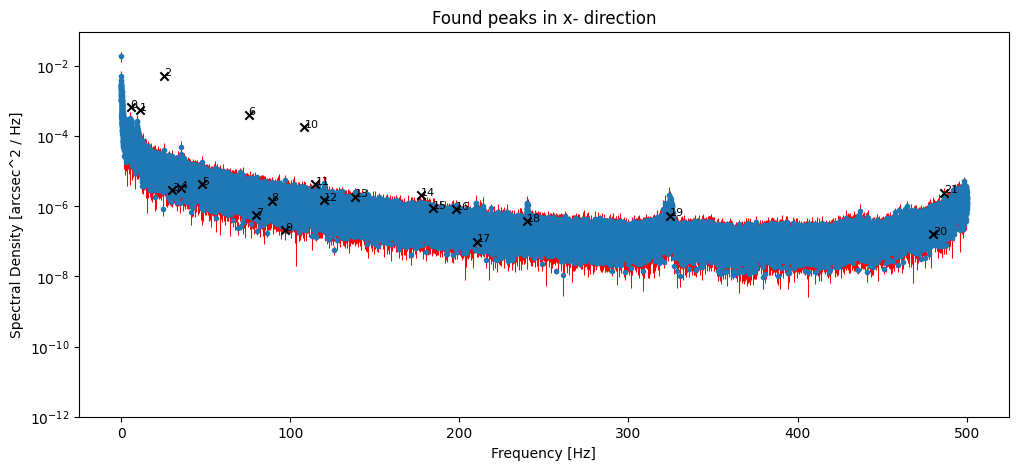

In [ ]:
bearingoff_electronicsoff_x_peaks = do_science_with_offset(bearingoff_electronicsoff_freqs_df, bearingoff_electronicsoff_x_avgs, bearingoff_electronicsoff_x_SEM, True, 'x',1e-6, 1e-7)

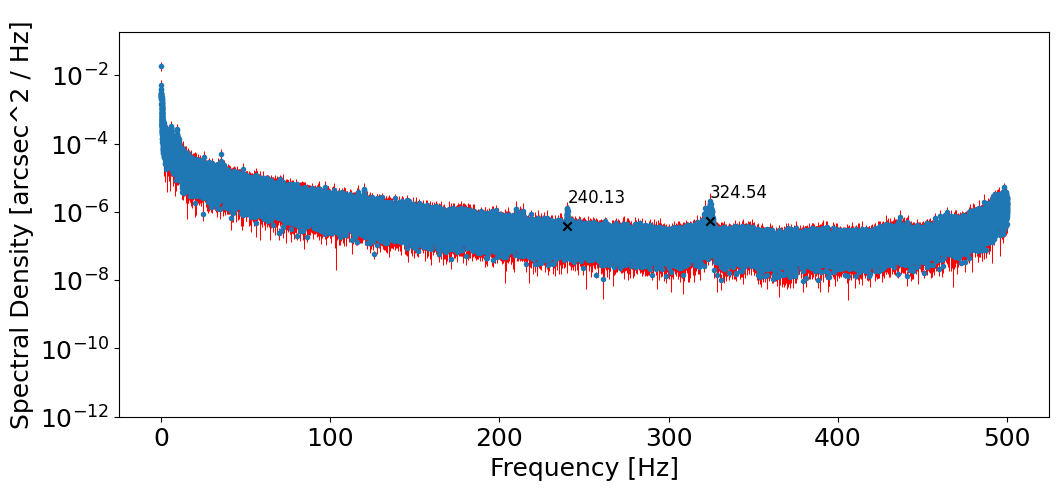

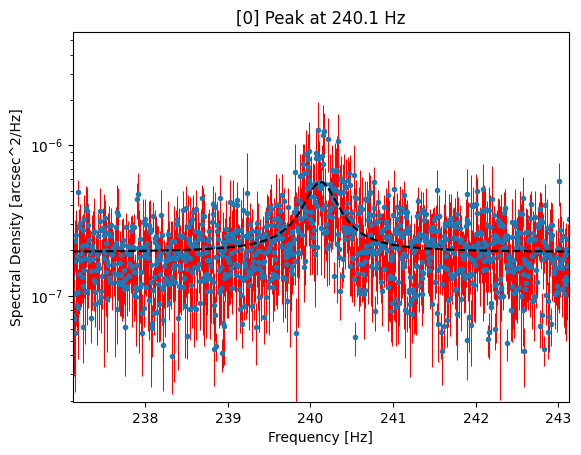

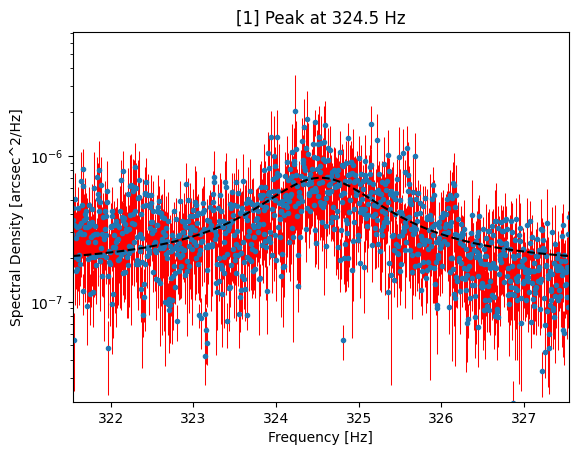

In [ ]:
x_peaks = [18,19] #indicies 18 and 19 were found by manual inspection
bearingoff_electronicsoff_real_xpeaks = keep_peaks_from(x_peaks, bearingoff_electronicsoff_x_peaks, 'Configuration_1_x.csv')
plot_peaks(bearingoff_electronicsoff_real_xpeaks, bearingoff_electronicsoff_freqs, bearingoff_electronicsoff_x_avgs,
           bearingoff_electronicsoff_x_SEM, ' ', 'x')

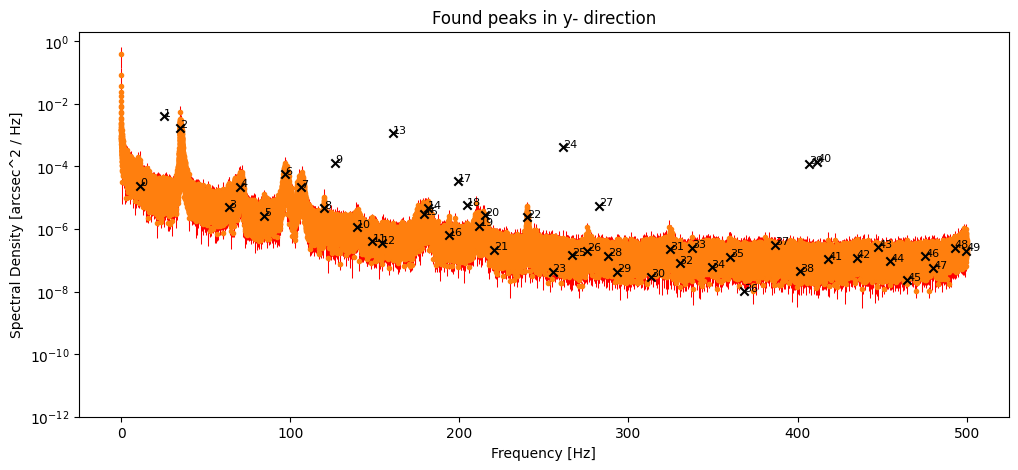

In [ ]:
bearingoff_electronicsoff_y_peaks = do_science_with_offset(bearingoff_electronicsoff_freqs_df, bearingoff_electronicsoff_y_avgs, bearingoff_electronicsoff_y_SEM, True, 'y',1e-7,0.5*1e-7)

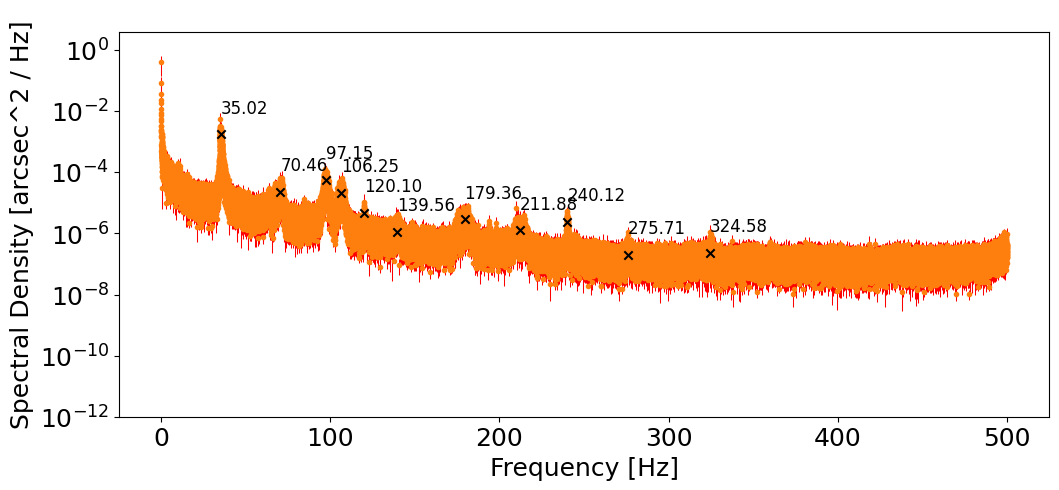

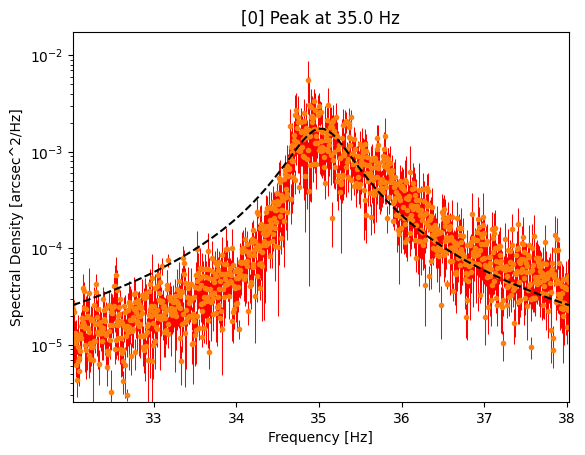

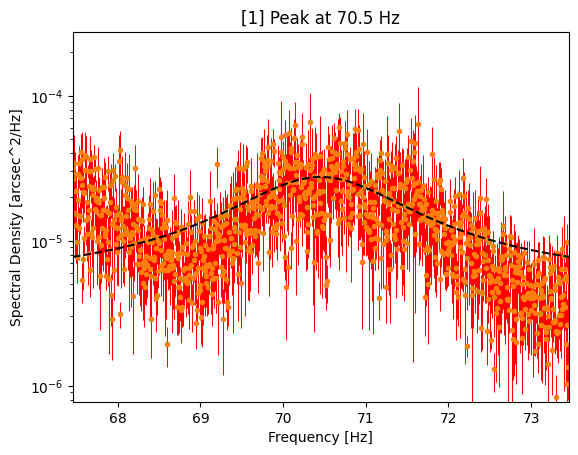

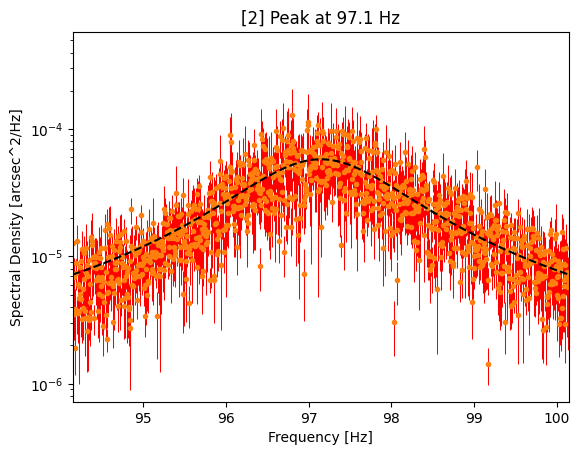

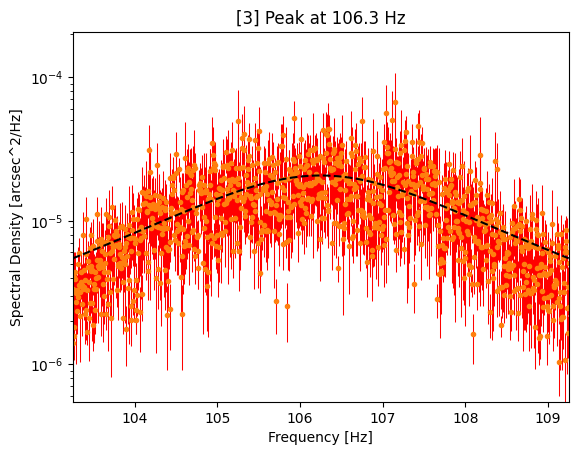

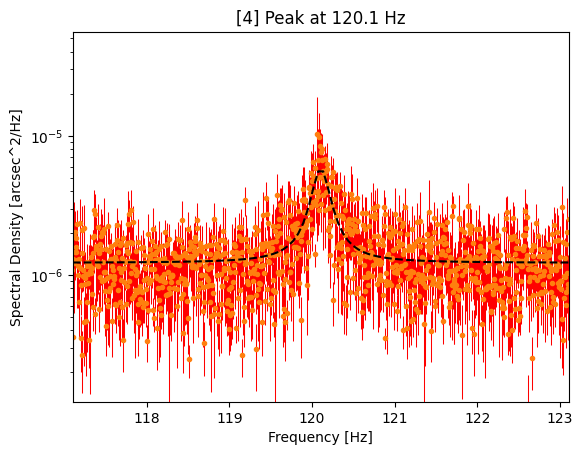

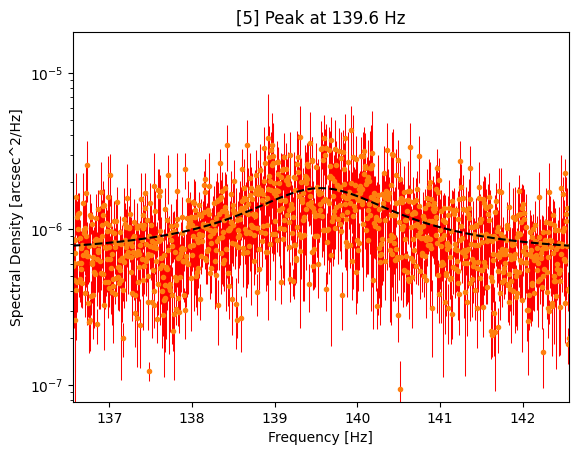

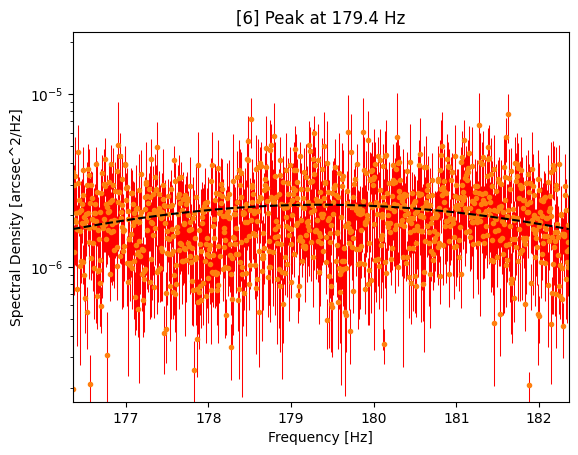

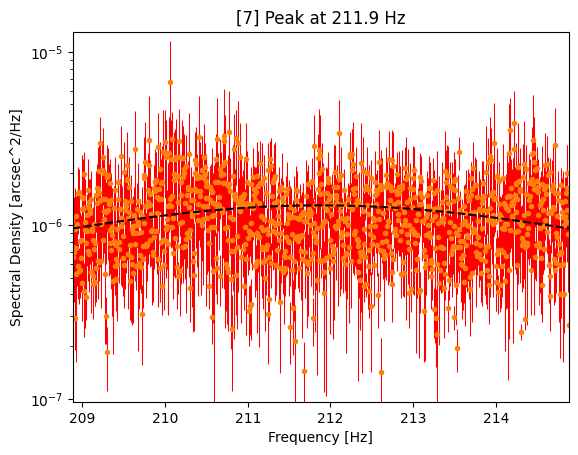

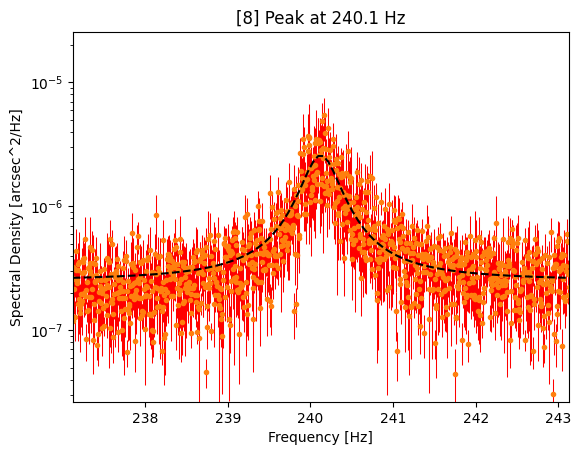

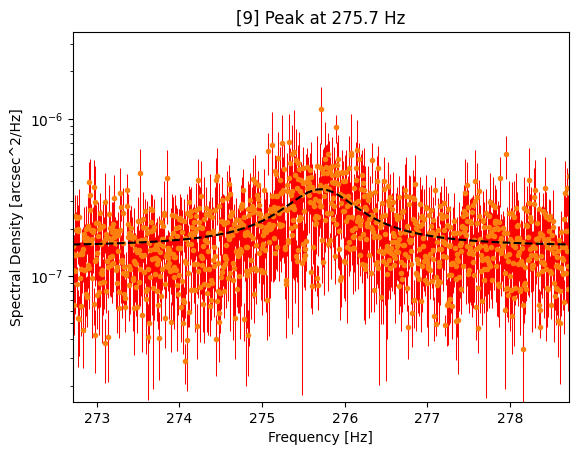

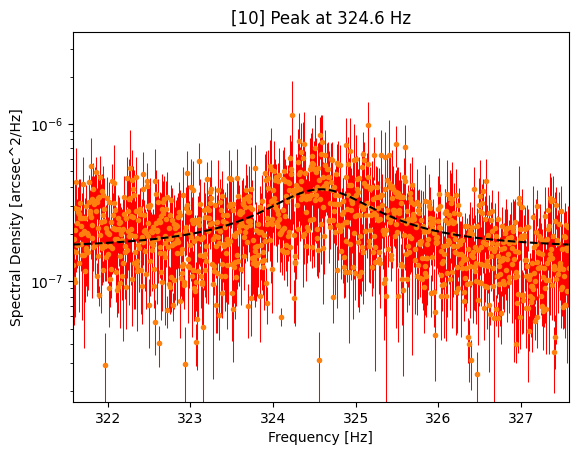

In [ ]:
y_peaks = [2, 4, 6,7,8, 10,15,19, 22, 26, 31]
bearingoff_electronicsoff_real_ypeaks = keep_peaks_from(y_peaks, bearingoff_electronicsoff_y_peaks, 'Configuration_1_y.csv')
plot_peaks(bearingoff_electronicsoff_real_ypeaks, bearingoff_electronicsoff_freqs, bearingoff_electronicsoff_y_avgs,
           bearingoff_electronicsoff_y_SEM, ' ', 'y')

# Configuration 2



This configuration features the air bearing off, the bus electronics on, the ADCS electronics ON, and the Payload (cryocooler and imaging system) ON.

The measured distances: 99.4 cm from the front edge of the jig to the detector and 100.0 cm from the front eduge of the jig to the front of the lens tube. Distance from to the front edge is 232.59 mm. From the CAD model, the lenght of the lens tube from the front of edge to the sensor housing is 51.6 mm and the distance from the front side hou sing to the actual sensor is 3.05 mm. This comes out to a total throw distance of 2.514 m.

In [ ]:
bearingoff_electronicson_throw_distance = 2.514 - 99.4e-2 - 232.59e-3
bearingoff_electronicson_throw_distance

1.2874099999999997

In [ ]:
# Read in data from the 1st trial of Configuration 2
bearingoff_electronicson_6 = np.genfromtxt('data_3_12_bearingoff_electronicson_6in_20230312-140845.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_6_xdata, bearingoff_electronicson_6_ydata, bearingoff_electronicson_6_vsum, bearingoff_electronicson_6_tdata = seperate_data_from(bearingoff_electronicson_6)
bearingoff_electronicson_6_xdisp = rad_to_arcsec((bearingoff_electronicson_6_xdata - np.mean(bearingoff_electronicson_6_xdata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_6_ydisp = rad_to_arcsec((bearingoff_electronicson_6_ydata - np.mean(bearingoff_electronicson_6_ydata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_6_xpsc_arcsec = power_spectrum(bearingoff_electronicson_6_tdata, bearingoff_electronicson_6_xdisp)
bearingoff_electronicson_6_ypsc_arcsec = power_spectrum(bearingoff_electronicson_6_tdata, bearingoff_electronicson_6_ydisp)

In [ ]:
# Read in and reduce data from 2nd trial of Configuration 2
bearingoff_electronicson_7 = np.genfromtxt('data_3_12_bearingoff_electronicson_7in_20230312-141327.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_7_xdata, bearingoff_electronicson_7_ydata, bearingoff_electronicson_7_vsum, bearingoff_electronicson_7_tdata = seperate_data_from(bearingoff_electronicson_7)
bearingoff_electronicson_7_xdisp = rad_to_arcsec((bearingoff_electronicson_7_xdata - np.mean(bearingoff_electronicson_7_xdata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_7_ydisp = rad_to_arcsec((bearingoff_electronicson_7_ydata - np.mean(bearingoff_electronicson_7_ydata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_7_xpsc_arcsec = power_spectrum(bearingoff_electronicson_7_tdata, bearingoff_electronicson_7_xdisp)
bearingoff_electronicson_7_ypsc_arcsec = power_spectrum(bearingoff_electronicson_7_tdata, bearingoff_electronicson_7_ydisp)

In [ ]:
# Read in and reduce data from 3rd trial of Configuration 2
bearingoff_electronicson_8 = np.genfromtxt('data_3_12_bearingoff_electronicson_8in_20230312-142003.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_8_xdata, bearingoff_electronicson_8_ydata, bearingoff_electronicson_8_vsum, bearingoff_electronicson_8_tdata = seperate_data_from(bearingoff_electronicson_8)
bearingoff_electronicson_8_xdisp = rad_to_arcsec((bearingoff_electronicson_8_xdata - np.mean(bearingoff_electronicson_8_xdata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_8_ydisp = rad_to_arcsec((bearingoff_electronicson_8_ydata - np.mean(bearingoff_electronicson_8_ydata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_8_xpsc_arcsec = power_spectrum(bearingoff_electronicson_8_tdata, bearingoff_electronicson_8_xdisp)
bearingoff_electronicson_8_ypsc_arcsec = power_spectrum(bearingoff_electronicson_8_tdata, bearingoff_electronicson_8_ydisp)

In [ ]:
# Read in and reduce data from 4th trial of Configuration 2
bearingoff_electronicson_9 = np.genfromtxt('data_3_12_bearingoff_electronicson_9in_20230312-142531.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_9_xdata, bearingoff_electronicson_9_ydata, bearingoff_electronicson_9_vsum, bearingoff_electronicson_9_tdata = seperate_data_from(bearingoff_electronicson_9)
bearingoff_electronicson_9_xdisp = rad_to_arcsec((bearingoff_electronicson_9_xdata - np.mean(bearingoff_electronicson_9_xdata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_9_ydisp = rad_to_arcsec((bearingoff_electronicson_9_ydata - np.mean(bearingoff_electronicson_9_ydata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_9_xpsc_arcsec = power_spectrum(bearingoff_electronicson_9_tdata, bearingoff_electronicson_9_xdisp)
bearingoff_electronicson_9_ypsc_arcsec = power_spectrum(bearingoff_electronicson_9_tdata, bearingoff_electronicson_9_ydisp)

In [ ]:
bearingoff_electronicson_10 = np.genfromtxt('data_3_12_bearingoff_electronicson_10in_20230312-142947.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_10_xdata, bearingoff_electronicson_10_ydata, bearingoff_electronicson_10_vsum, bearingoff_electronicson_10_tdata = seperate_data_from(bearingoff_electronicson_10)
bearingoff_electronicson_10_xdisp = rad_to_arcsec((bearingoff_electronicson_10_xdata - np.mean(bearingoff_electronicson_10_xdata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_10_ydisp = rad_to_arcsec((bearingoff_electronicson_10_ydata - np.mean(bearingoff_electronicson_10_ydata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_10_xpsc_arcsec = power_spectrum(bearingoff_electronicson_10_tdata, bearingoff_electronicson_10_xdisp)
bearingoff_electronicson_10_ypsc_arcsec = power_spectrum(bearingoff_electronicson_10_tdata, bearingoff_electronicson_10_ydisp)

In [ ]:
bearingoff_electronicson_11 = np.genfromtxt('data_3_12_bearingoff_electronicson_11in_20230312-143437.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_11_xdata, bearingoff_electronicson_11_ydata, bearingoff_electronicson_11_vsum, bearingoff_electronicson_11_tdata = seperate_data_from(bearingoff_electronicson_11)
bearingoff_electronicson_11_xdisp = rad_to_arcsec((bearingoff_electronicson_11_xdata - np.mean(bearingoff_electronicson_11_xdata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_11_ydisp = rad_to_arcsec((bearingoff_electronicson_11_ydata - np.mean(bearingoff_electronicson_11_ydata)) / bearingoff_electronicson_throw_distance)
bearingoff_electronicson_11_xpsc_arcsec = power_spectrum(bearingoff_electronicson_11_tdata, bearingoff_electronicson_11_xdisp)
bearingoff_electronicson_11_ypsc_arcsec = power_spectrum(bearingoff_electronicson_11_tdata, bearingoff_electronicson_11_ydisp)

In [ ]:
bearingoff_electronicson_xspec_powers = pd.DataFrame([bearingoff_electronicson_6_xpsc_arcsec[1], bearingoff_electronicson_7_xpsc_arcsec[1],bearingoff_electronicson_8_xpsc_arcsec[1],
                                                      bearingoff_electronicson_9_xpsc_arcsec[1], bearingoff_electronicson_10_xpsc_arcsec[1], bearingoff_electronicson_11_xpsc_arcsec[1]])
bearingoff_electronicson_yspec_powers = pd.DataFrame([bearingoff_electronicson_6_ypsc_arcsec[1], bearingoff_electronicson_7_ypsc_arcsec[1],bearingoff_electronicson_8_ypsc_arcsec[1],
                                                      bearingoff_electronicson_9_ypsc_arcsec[1], bearingoff_electronicson_10_ypsc_arcsec[1], bearingoff_electronicson_11_ypsc_arcsec[1]])

In [ ]:
bearingoff_electronicson_xspec_avgs = bearingoff_electronicson_xspec_powers.mean(axis = 0)
bearingoff_electronicson_xspec_sem = bearingoff_electronicson_xspec_powers.sem(axis = 0)
bearingoff_electronicson_yspec_avgs = bearingoff_electronicson_yspec_powers.mean(axis = 0)
bearingoff_electronicson_yspec_sem = bearingoff_electronicson_yspec_powers.sem(axis = 0)

In [ ]:
bearingoff_electronicson_x_var = np.sqrt(scipy.integrate.trapezoid(np.asarray(bearingoff_electronicson_xspec_avgs.iloc[25020:]).flatten(),
                                                                      np.asarray(freqs_df.iloc[25020:]).flatten()))
bearingoff_electronicson_y_var = np.sqrt(scipy.integrate.trapezoid(np.asarray(bearingoff_electronicson_yspec_avgs.iloc[25020:]).flatten(),
                                                                      np.asarray(freqs_df.iloc[25020:]).flatten()))
bearingoff_electronicson_x_var, bearingoff_electronicson_y_var

(0.040174895747356464, 0.04571363366631322)

In [ ]:
# Compute total variance, assuming variances are independent
bearingoff_electronicson_var = bearingoff_electronicson_x_var + bearingoff_electronicson_y_var
bearingoff_electronicson_var

0.08588852941366969

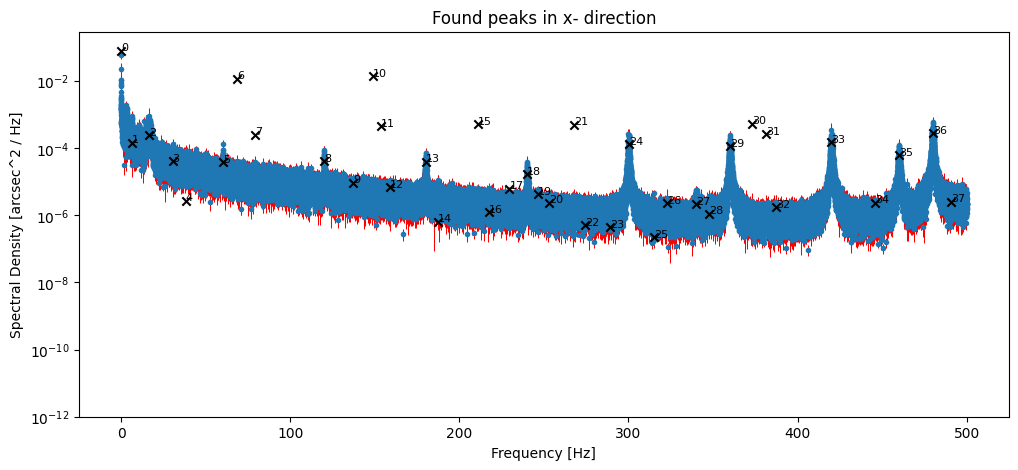

In [ ]:
bearingoff_electronicson_xpeaks = do_science_with_offset(freqs_df, bearingoff_electronicson_xspec_avgs, bearingoff_electronicson_xspec_sem, True, 'x',1e-6, 1e-7)

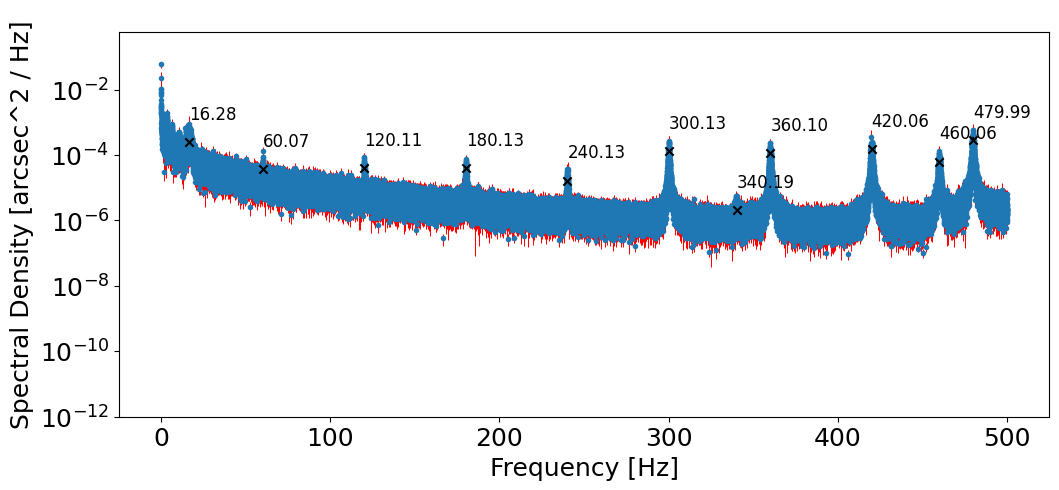

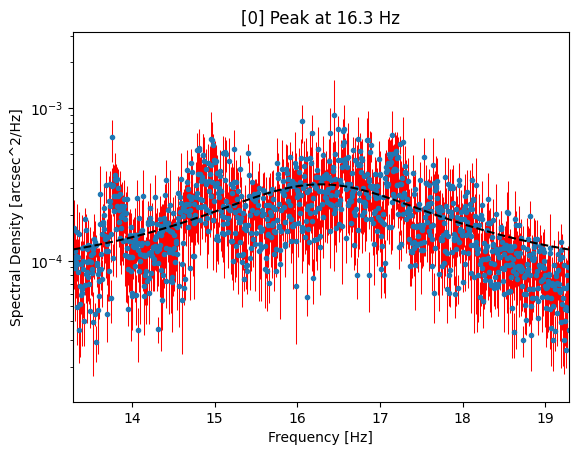

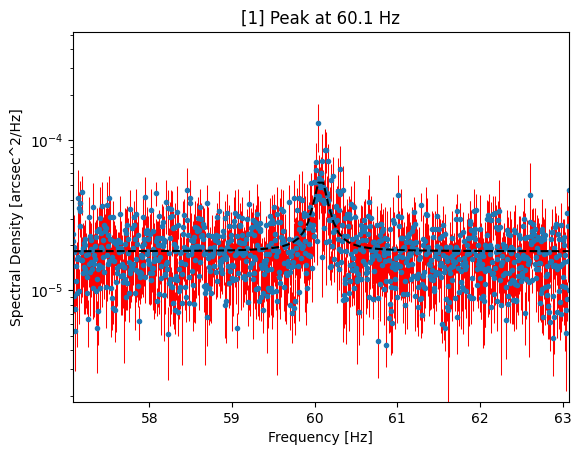

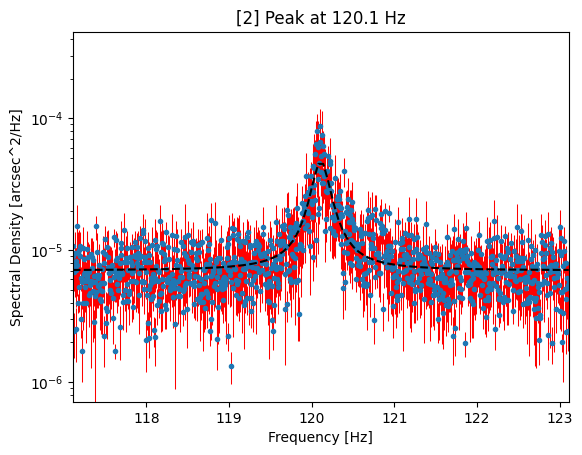

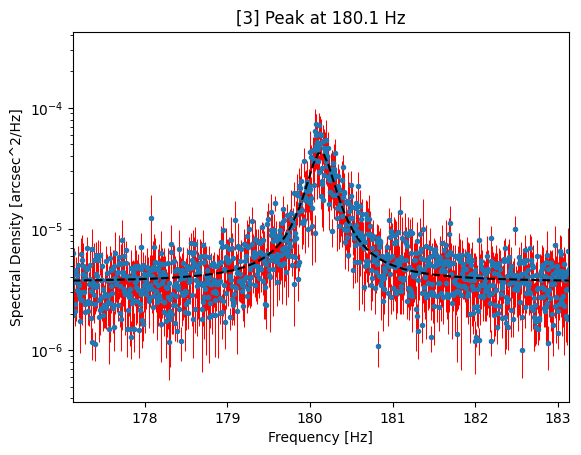

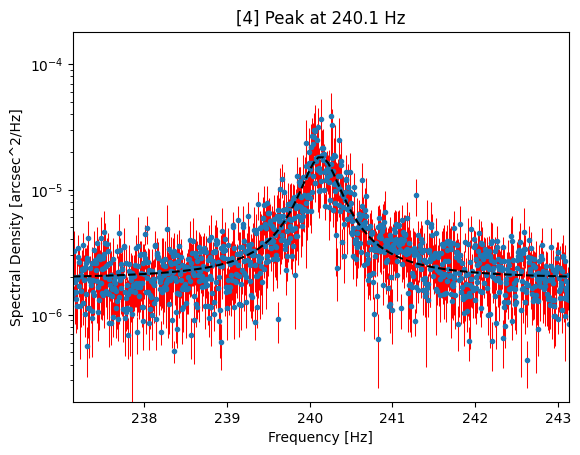

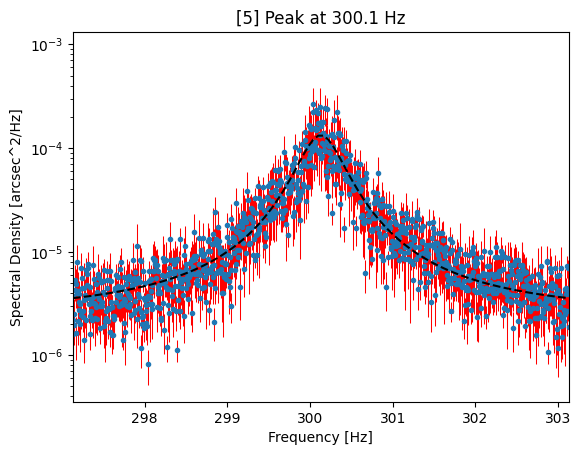

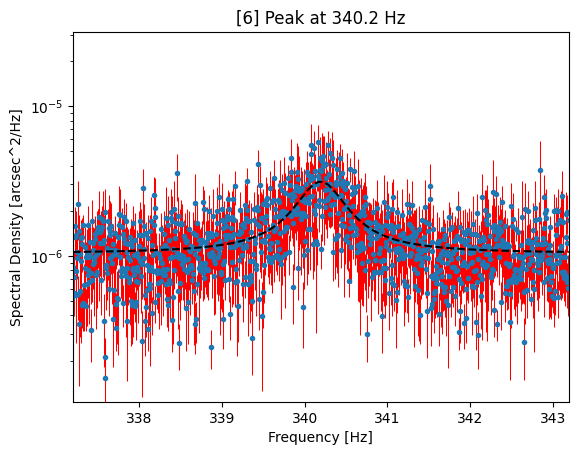

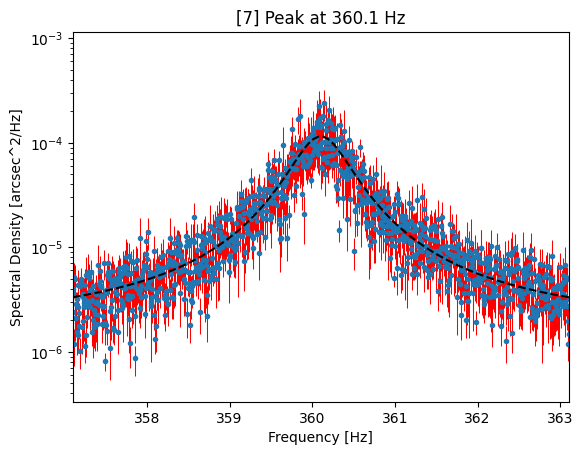

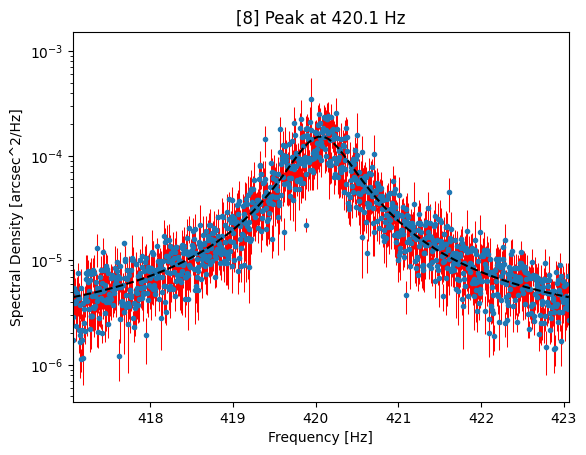

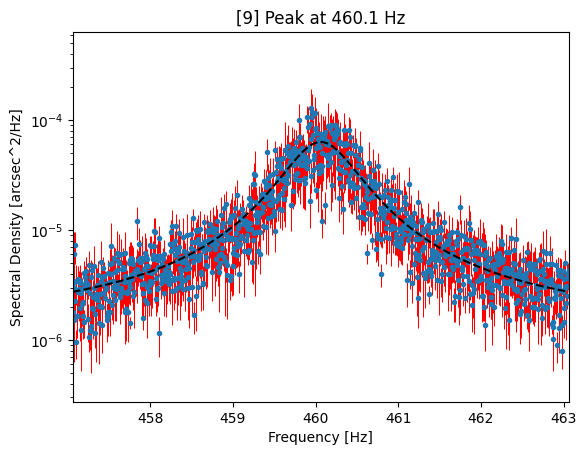

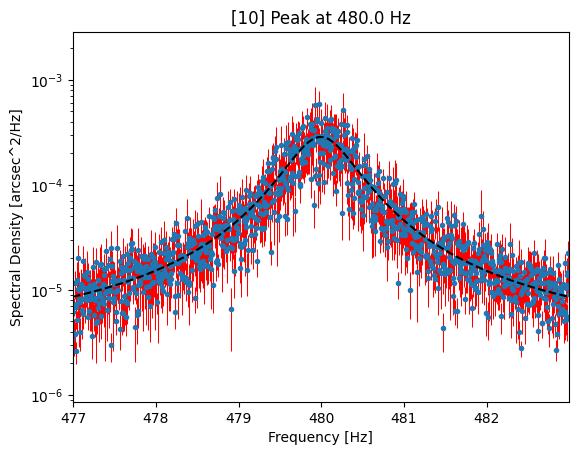

In [ ]:
x_peaks = [2,5,8,13,18, 24, 27,29,33,35,36]

# Use the keep peaks function and plot
bearingoff_electronicson_real_xpeaks = keep_peaks_from(x_peaks, bearingoff_electronicson_xpeaks, 'Configuration_2_x.csv')
plot_peaks(bearingoff_electronicson_real_xpeaks, bearingoff_electronicsoff_freqs, bearingoff_electronicson_xspec_avgs,
           bearingoff_electronicson_xspec_sem, ' ', 'x')

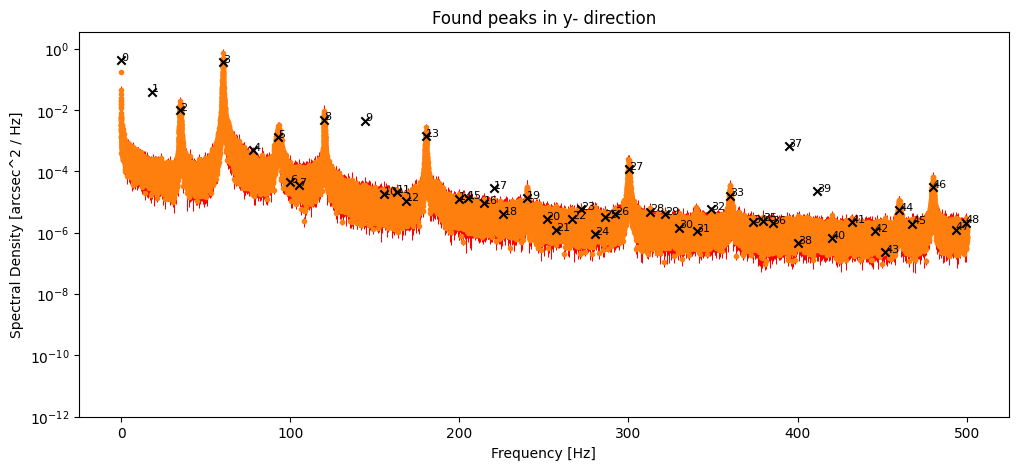

In [ ]:
bearingoff_electronicson_ypeaks = do_science_with_offset(freqs_df, bearingoff_electronicson_yspec_avgs, bearingoff_electronicson_yspec_sem, True, 'y',1e-6, 1e-7)

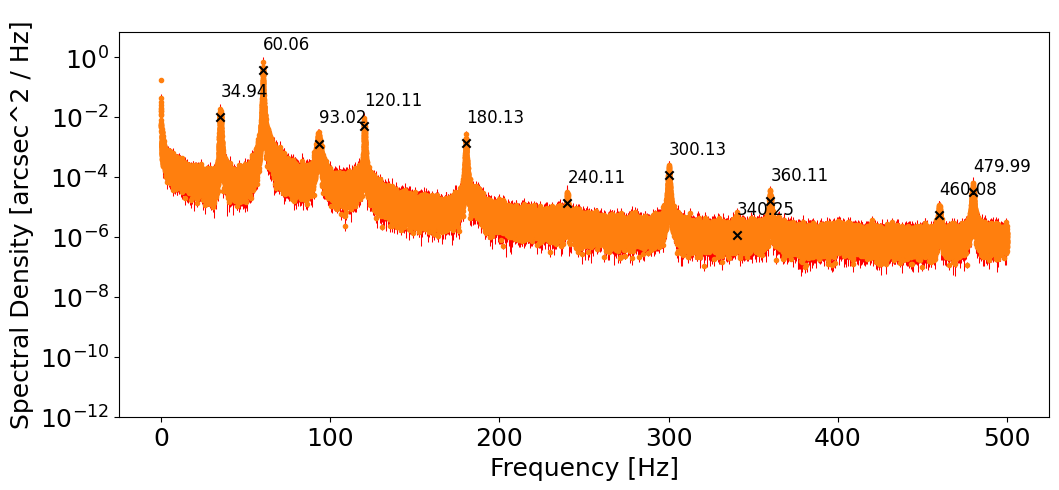

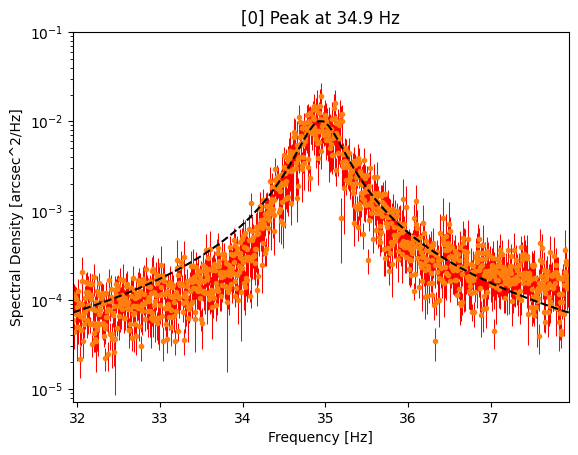

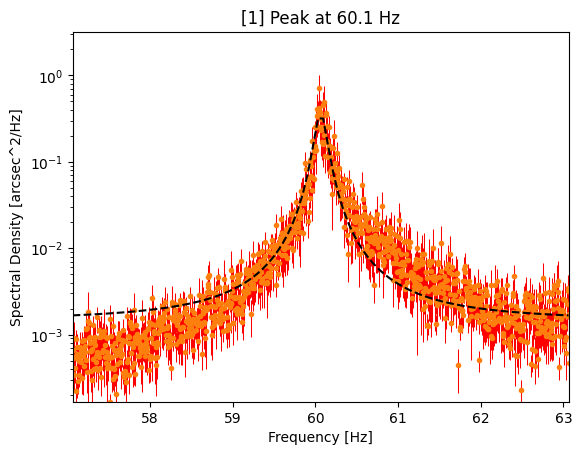

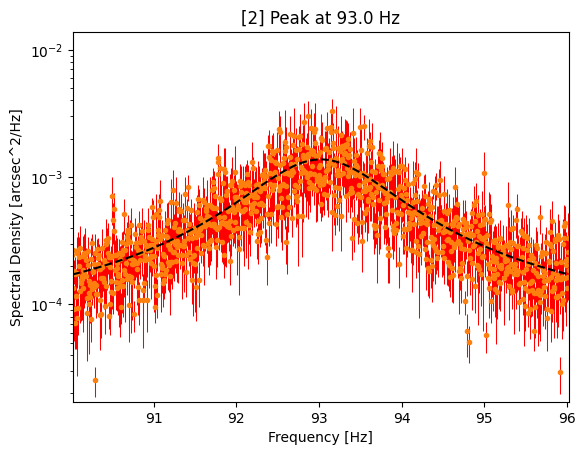

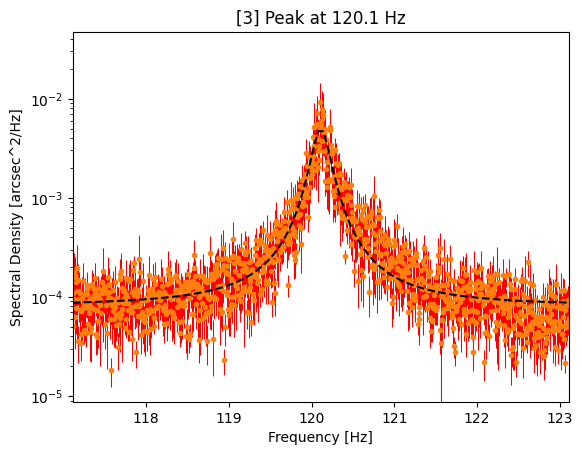

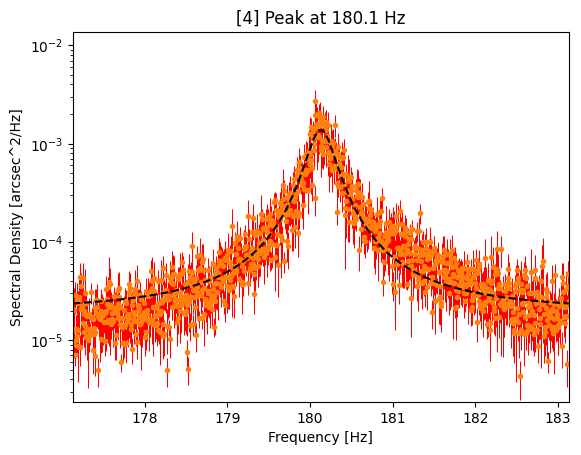

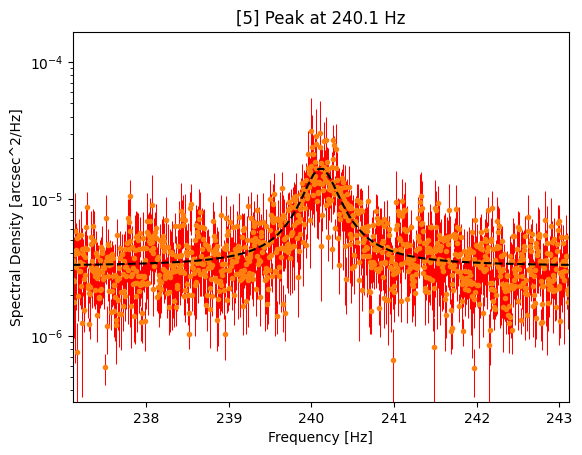

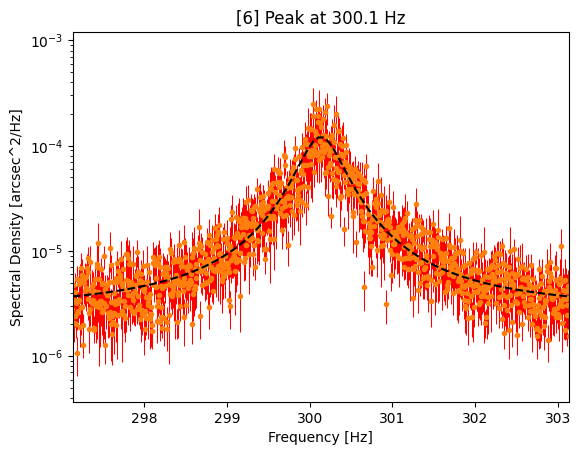

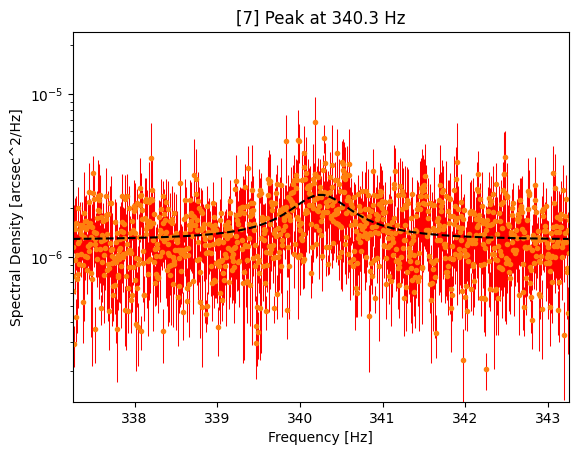

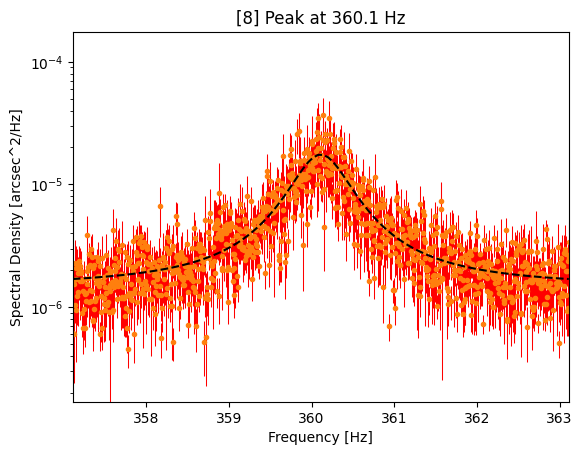

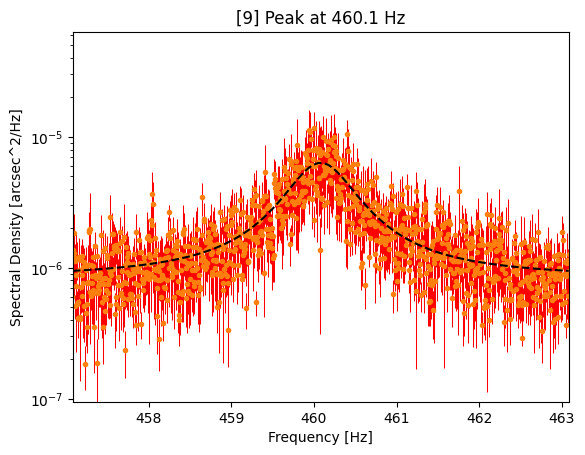

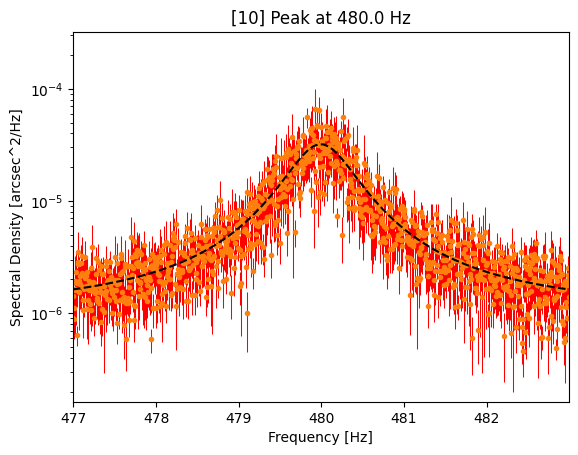

In [ ]:
y_peaks = [2,3,5,8,13,19,27,31,33,44,46]

# Use the keep peaks function and plot
bearingoff_electronicson_real_ypeaks = keep_peaks_from(y_peaks, bearingoff_electronicson_ypeaks, 'Configuration_2_y.csv')
plot_peaks(bearingoff_electronicson_real_ypeaks, bearingoff_electronicsoff_freqs, bearingoff_electronicson_yspec_avgs,
           bearingoff_electronicson_yspec_sem, ' ', 'y')

# Configuration 3

In [18]:
bearingon_electronicsoff_1 = np.genfromtxt('data_3_13_bearingon_electronicsoff_1in_20230313-173321.csv', delimiter = ',', skip_header = 2)
bearingon_electronicsoff_1_xdata, bearingon_electronicsoff_1_ydata, bearingon_electronicsoff_1_vsum, bearingon_electronicsoff_1_tdata = seperate_data_from(bearingon_electronicsoff_1)
bearingon_electronicsoff_1_xdisp = rad_to_arcsec(((bearingon_electronicsoff_1_xdata) - np.mean(bearingon_electronicsoff_1_xdata)) / throw_distance)
bearingon_electronicsoff_1_ydisp = rad_to_arcsec(((bearingon_electronicsoff_1_ydata) - np.mean(bearingon_electronicsoff_1_ydata)) / throw_distance)
bearingon_electronicsoff_1_xpsc_arcsec = power_spectrum(bearingon_electronicsoff_1_tdata, bearingon_electronicsoff_1_xdisp)
bearingon_electronicsoff_1_ypsc_arcsec = power_spectrum(bearingon_electronicsoff_1_tdata, bearingon_electronicsoff_1_ydisp)

In [19]:
bearingon_electronicsoff_2 = np.genfromtxt('data_3_13_bearingon_electronicsoff_2in_20230313-173723.csv', delimiter = ',', skip_header = 2)
bearingon_electronicsoff_2_xdata, bearingon_electronicsoff_2_ydata, bearingon_electronicsoff_2_vsum, bearingon_electronicsoff_2_tdata = seperate_data_from(bearingon_electronicsoff_2)
bearingon_electronicsoff_2_xdisp = rad_to_arcsec(((bearingon_electronicsoff_2_xdata) - np.mean(bearingon_electronicsoff_2_xdata)) / throw_distance)
bearingon_electronicsoff_2_ydisp = rad_to_arcsec(((bearingon_electronicsoff_2_ydata) - np.mean(bearingon_electronicsoff_2_ydata)) / throw_distance)
bearingon_electronicsoff_2_xpsc_arcsec = power_spectrum(bearingon_electronicsoff_2_tdata, bearingon_electronicsoff_2_xdisp)
bearingon_electronicsoff_2_ypsc_arcsec = power_spectrum(bearingon_electronicsoff_2_tdata, bearingon_electronicsoff_2_ydisp)

In [20]:
bearingon_electronicsoff_3 = np.genfromtxt('data_3_13_bearingon_electronicsoff_3in_20230313-174216.csv', delimiter = ',', skip_header = 2)
bearingon_electronicsoff_3_xdata, bearingon_electronicsoff_3_ydata, bearingon_electronicsoff_3_vsum, bearingon_electronicsoff_3_tdata = seperate_data_from(bearingon_electronicsoff_3)
bearingon_electronicsoff_3_xdisp = rad_to_arcsec(((bearingon_electronicsoff_3_xdata) - np.mean(bearingon_electronicsoff_3_xdata)) / throw_distance)
bearingon_electronicsoff_3_ydisp = rad_to_arcsec(((bearingon_electronicsoff_3_ydata) - np.mean(bearingon_electronicsoff_3_ydata)) / throw_distance)
bearingon_electronicsoff_3_xpsc_arcsec = power_spectrum(bearingon_electronicsoff_3_tdata, bearingon_electronicsoff_3_xdisp)
bearingon_electronicsoff_3_ypsc_arcsec = power_spectrum(bearingon_electronicsoff_3_tdata, bearingon_electronicsoff_3_ydisp)

In [21]:
bearingon_electronicsoff_4 = np.genfromtxt('data_3_13_bearingon_electronicsoff_4in_20230313-174842.csv', delimiter = ',', skip_header = 2)
bearingon_electronicsoff_4_xdata, bearingon_electronicsoff_4_ydata, bearingon_electronicsoff_4_vsum, bearingon_electronicsoff_4_tdata = seperate_data_from(bearingon_electronicsoff_4)
bearingon_electronicsoff_4_xdisp = rad_to_arcsec(((bearingon_electronicsoff_4_xdata) - np.mean(bearingon_electronicsoff_4_xdata)) / throw_distance)
bearingon_electronicsoff_4_ydisp = rad_to_arcsec(((bearingon_electronicsoff_4_ydata) - np.mean(bearingon_electronicsoff_4_ydata)) / throw_distance)
bearingon_electronicsoff_4_xpsc_arcsec = power_spectrum(bearingon_electronicsoff_4_tdata, bearingon_electronicsoff_4_xdisp)
bearingon_electronicsoff_4_ypsc_arcsec = power_spectrum(bearingon_electronicsoff_4_tdata, bearingon_electronicsoff_4_ydisp)

In [22]:
bearingon_electronicsoff_5 = np.genfromtxt('data_3_13_bearingon_electronicsoff_5in_20230313-175259.csv', delimiter = ',', skip_header = 2)
bearingon_electronicsoff_5_xdata, bearingon_electronicsoff_5_ydata, bearingon_electronicsoff_5_vsum, bearingon_electronicsoff_5_tdata = seperate_data_from(bearingon_electronicsoff_5)
bearingon_electronicsoff_5_xdisp = rad_to_arcsec(((bearingon_electronicsoff_5_xdata) - np.mean(bearingon_electronicsoff_5_xdata)) / throw_distance)
bearingon_electronicsoff_5_ydisp = rad_to_arcsec(((bearingon_electronicsoff_5_ydata) - np.mean(bearingon_electronicsoff_5_ydata)) / throw_distance)
bearingon_electronicsoff_5_xpsc_arcsec = power_spectrum(bearingon_electronicsoff_5_tdata, bearingon_electronicsoff_5_xdisp)
bearingon_electronicsoff_5_ypsc_arcsec = power_spectrum(bearingon_electronicsoff_5_tdata, bearingon_electronicsoff_5_ydisp)

In [23]:
bearingon_electronicsoff_psds_x = pd.DataFrame([bearingon_electronicsoff_1_xpsc_arcsec[1], bearingon_electronicsoff_2_xpsc_arcsec[1], bearingon_electronicsoff_2_xpsc_arcsec[1],
                                                      bearingon_electronicsoff_4_xpsc_arcsec[1], bearingon_electronicsoff_5_xpsc_arcsec[1]])
bearingon_electronicsoff_psds_y = pd.DataFrame([bearingon_electronicsoff_1_ypsc_arcsec[1], bearingon_electronicsoff_2_ypsc_arcsec[1], bearingon_electronicsoff_3_ypsc_arcsec[1],
                                                      bearingon_electronicsoff_4_ypsc_arcsec[1], bearingon_electronicsoff_5_ypsc_arcsec[1]])

#get the frequency divisions from any one of the psd plots a robust test would check all combinations, but I'm going to assume pcking two randomly shall suffice.
if np.array_equiv(bearingon_electronicsoff_1_xpsc_arcsec[0], bearingon_electronicsoff_5_ypsc_arcsec[0]):
  bearingon_electronicsoff_freqs = bearingon_electronicsoff_1_xpsc_arcsec[0]
  bearingon_electronicsoff_freqs_df = data_as_df(bearingon_electronicsoff_freqs)
else:
  raise Exception("Frequency binning does not match")

bearingon_electronicsoff_x_avgs = bearingon_electronicsoff_psds_x.mean(axis = 0)
bearingon_electronicsoff_x_SEM = bearingon_electronicsoff_psds_x.sem(axis = 0)
bearingon_electronicsoff_y_avgs = bearingon_electronicsoff_psds_y.mean(axis = 0)
bearingon_electronicsoff_y_SEM = bearingon_electronicsoff_psds_y.sem(axis =  0)

In [24]:
# Convert these to dataframes
bearingon_electronicsoff_x_avgs_df = data_as_df(bearingon_electronicsoff_x_avgs)
bearingon_electronicsoff_y_avgs_df = data_as_df(bearingon_electronicsoff_y_avgs)

In [25]:
bearingon_electronicsoff_x_var = (scipy.integrate.trapezoid(np.asarray(bearingon_electronicsoff_x_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_electronicsoff_freqs_df.iloc[25020:]).flatten()))
bearingon_electronicsoff_y_var = (scipy.integrate.trapezoid(np.asarray(bearingon_electronicsoff_y_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_electronicsoff_freqs_df.iloc[25020:]).flatten()))
bearingon_electronicsoff_var = bearingon_electronicsoff_x_var + bearingon_electronicsoff_y_var

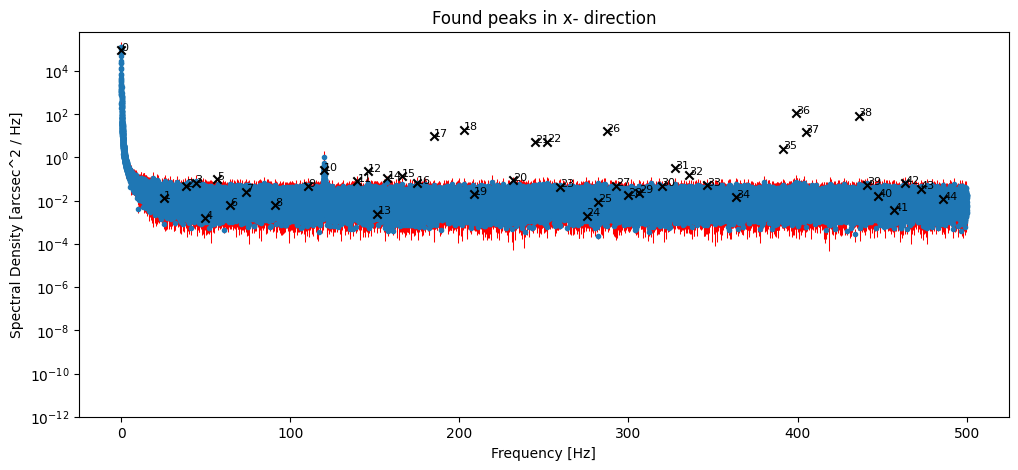

In [26]:
bearingon_electronicsoff_x_peaks = do_science_with_offset(bearingon_electronicsoff_freqs_df, bearingon_electronicsoff_x_avgs, bearingon_electronicsoff_x_SEM, True, 'x', 1e-6, 5e-7)

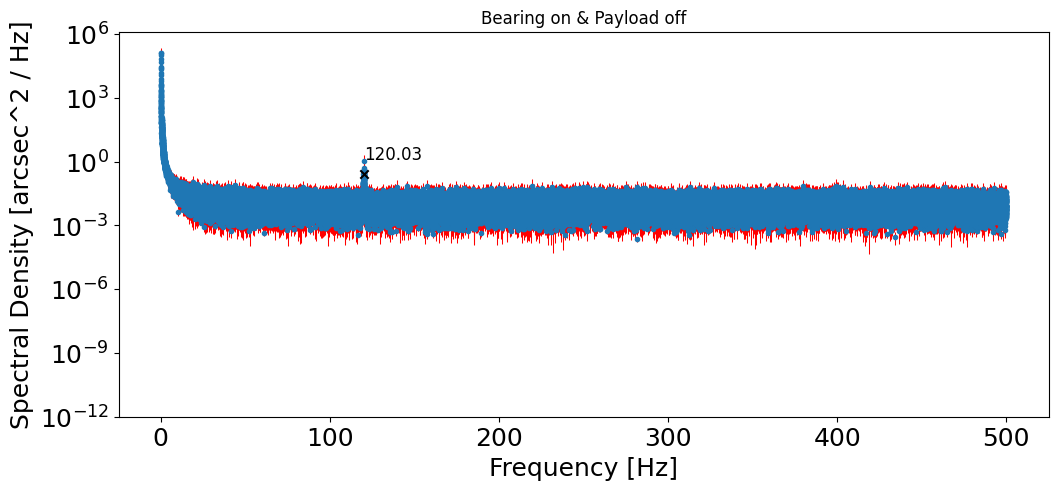

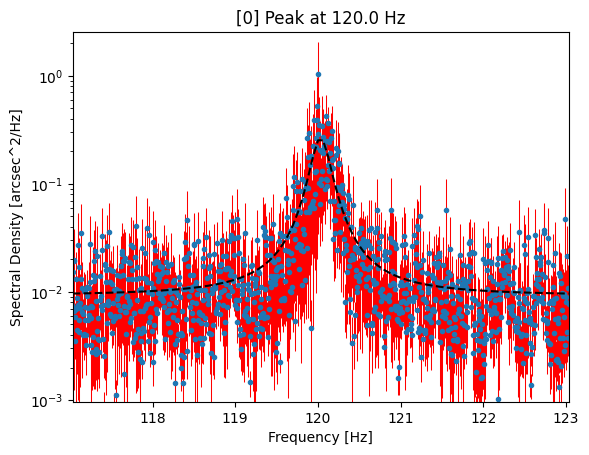

In [28]:
bearingon_electronicsoff_peak_numbers = [10]
bearingon_electronicsoff_real_xpeaks = keep_peaks_from(bearingon_electronicsoff_peak_numbers, bearingon_electronicsoff_x_peaks, 'Configuration_3_x.csv')
plot_peaks(bearingon_electronicsoff_real_xpeaks, bearingon_electronicsoff_freqs, bearingon_electronicsoff_x_avgs,
           bearingon_electronicsoff_x_SEM, 'Bearing on & Payload off', 'x')

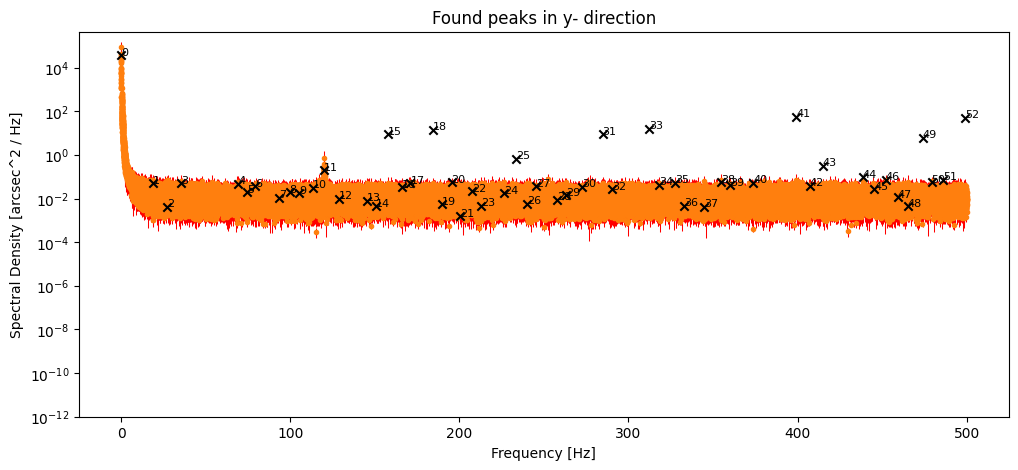

In [29]:
bearingon_electronicsoff_y_peaks = do_science_with_offset(bearingon_electronicsoff_freqs_df, bearingon_electronicsoff_y_avgs, bearingon_electronicsoff_y_SEM, True, 'y',1e-2, 1e-3)

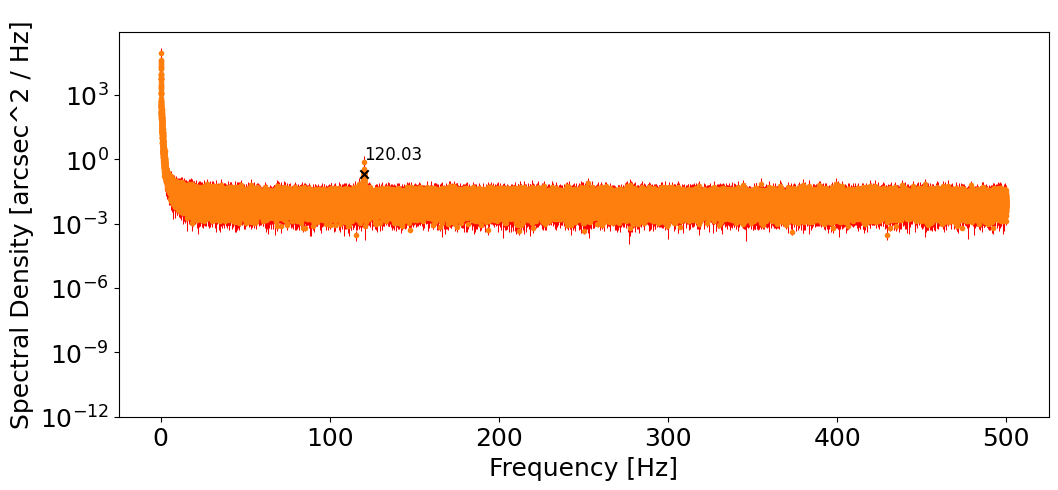

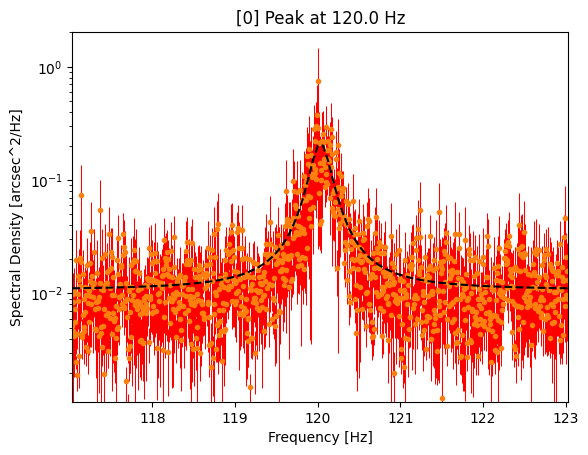

In [31]:
bearingon_electronicsoff_ypeak_numbers = [11]
bearingon_electronicsoff_real_ypeaks = keep_peaks_from(bearingon_electronicsoff_ypeak_numbers, bearingon_electronicsoff_y_peaks, 'Configuration_3_y.csv')
plot_peaks(bearingon_electronicsoff_real_ypeaks, bearingon_electronicsoff_freqs, bearingon_electronicsoff_y_avgs,
           bearingon_electronicsoff_y_SEM, ' ', 'y')

# Configuration 4
 In this configuration, the air bearing is on, the bus electronics are on, and the ADCS electronics are on - but the actuators (i.e. the reaction wheels) are not active.



In [32]:
bearingon_adcselectronicson_1 = np.genfromtxt('data_3_13_bearingon_adcselectronicson_1in_20230313-175858.csv', delimiter = ',', skip_header = 2)
bearingon_adcselectronicson_1_xdata, bearingon_adcselectronicson_1_ydata, bearingon_adcselectronicson_1_vsum, bearingon_adcselectronicson_1_tdata = seperate_data_from(bearingon_adcselectronicson_1)
bearingon_adcselectronicson_1_xdisp = rad_to_arcsec(((bearingon_adcselectronicson_1_xdata) - np.mean(bearingon_adcselectronicson_1_xdata)) / throw_distance)
bearingon_adcselectronicson_1_ydisp = rad_to_arcsec(((bearingon_adcselectronicson_1_ydata) - np.mean(bearingon_adcselectronicson_1_ydata)) / throw_distance)
bearingon_adcselectronicson_1_xpsc_arcsec = power_spectrum(bearingon_adcselectronicson_1_tdata, bearingon_adcselectronicson_1_xdisp)
bearingon_adcselectronicson_1_ypsc_arcsec = power_spectrum(bearingon_adcselectronicson_1_tdata, bearingon_adcselectronicson_1_ydisp)

In [33]:
bearingon_adcselectronicson_2 = np.genfromtxt('data_3_13_bearingon_adcselectronicson_2in_20230313-180244.csv', delimiter = ',', skip_header = 2)
bearingon_adcselectronicson_2_xdata, bearingon_adcselectronicson_2_ydata, bearingon_adcselectronicson_2_vsum, bearingon_adcselectronicson_2_tdata = seperate_data_from(bearingon_adcselectronicson_2)
bearingon_adcselectronicson_2_xdisp = rad_to_arcsec(((bearingon_adcselectronicson_2_xdata) - np.mean(bearingon_adcselectronicson_2_xdata)) / throw_distance)
bearingon_adcselectronicson_2_ydisp = rad_to_arcsec(((bearingon_adcselectronicson_2_ydata) - np.mean(bearingon_adcselectronicson_2_ydata)) / throw_distance)
bearingon_adcselectronicson_2_xpsc_arcsec = power_spectrum(bearingon_adcselectronicson_2_tdata, bearingon_adcselectronicson_2_xdisp)
bearingon_adcselectronicson_2_ypsc_arcsec = power_spectrum(bearingon_adcselectronicson_2_tdata, bearingon_adcselectronicson_2_ydisp)

In [34]:
bearingon_adcselectronicson_3 = np.genfromtxt('data_3_13_bearingon_adcselectronicson_3in_20230313-180718.csv', delimiter = ',', skip_header = 2)
bearingon_adcselectronicson_3_xdata, bearingon_adcselectronicson_3_ydata, bearingon_adcselectronicson_3_vsum, bearingon_adcselectronicson_3_tdata = seperate_data_from(bearingon_adcselectronicson_3)
bearingon_adcselectronicson_3_xdisp = rad_to_arcsec(((bearingon_adcselectronicson_3_xdata) - np.mean(bearingon_adcselectronicson_3_xdata)) / throw_distance)
bearingon_adcselectronicson_3_ydisp = rad_to_arcsec(((bearingon_adcselectronicson_3_ydata) - np.mean(bearingon_adcselectronicson_3_ydata)) / throw_distance)
bearingon_adcselectronicson_3_xpsc_arcsec = power_spectrum(bearingon_adcselectronicson_3_tdata, bearingon_adcselectronicson_3_xdisp)
bearingon_adcselectronicson_3_ypsc_arcsec = power_spectrum(bearingon_adcselectronicson_3_tdata, bearingon_adcselectronicson_3_ydisp)

In [35]:
# Concatenate the psd trials.
bearingon_adcselectronicson_x_psds = pd.DataFrame([bearingon_adcselectronicson_1_xpsc_arcsec[1], bearingon_adcselectronicson_2_xpsc_arcsec[1],
                                        bearingon_adcselectronicson_3_xpsc_arcsec[1]])

bearingon_adcselectronicson_y_psds = pd.DataFrame([bearingon_adcselectronicson_1_ypsc_arcsec[1], bearingon_adcselectronicson_2_ypsc_arcsec[1],
                                        bearingon_adcselectronicson_3_ypsc_arcsec[1]])

# Get the frequency divisions from any one of the psd plots a robust test would check all combinations, but I'm going to assume pcking two randomly shall suffice.
if np.array_equiv(bearingon_adcselectronicson_1_xpsc_arcsec[0], bearingon_adcselectronicson_3_ypsc_arcsec[0]):
  bearingon_adcselectronicson_freqs = data_as_df(bearingon_adcselectronicson_1_xpsc_arcsec[0])
else:
  raise Exception("Frequency binning does not match")

In [36]:
# Find the averages and SEM of the concated arrays
bearingon_adcselectronicson_x_avgs = bearingon_adcselectronicson_x_psds.mean(axis = 0)
bearingon_adcselectronicson_x_SEM = bearingon_adcselectronicson_x_psds.sem(axis = 0)
bearingon_adcselectronicson_y_avgs = bearingon_adcselectronicson_y_psds.mean(axis = 0)
bearingon_adcselectronicson_y_SEM = bearingon_adcselectronicson_y_psds.sem(axis =  0)

# Convert these to dfs
bearingon_adcselectronicson_x_avgs_df = data_as_df(bearingon_adcselectronicson_x_avgs)
bearingon_adcselectronicson_y_avgs_df = data_as_df(bearingon_adcselectronicson_y_avgs)
bearingon_adcselectronicson_freqs_df = data_as_df(bearingon_adcselectronicson_freqs)

# Calculate the variance
bearingon_adcselectronicson_x_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcselectronicson_x_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcselectronicson_freqs_df.iloc[25020:]).flatten()))
bearingon_adcselectronicson_y_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcselectronicson_y_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcselectronicson_freqs_df.iloc[25020:]).flatten()))

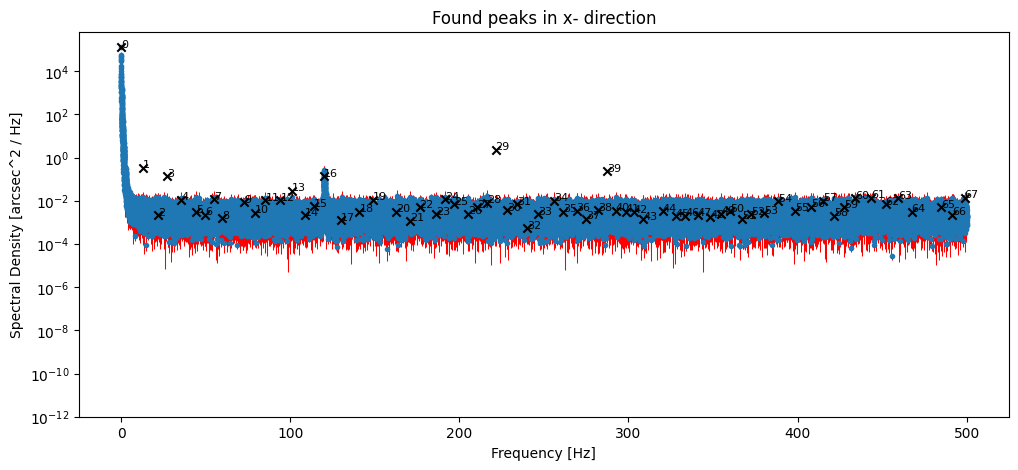

In [37]:
bearingon_adcselectronicson_x_peaks = do_science_with_offset(bearingon_adcselectronicson_freqs, bearingon_adcselectronicson_x_avgs, bearingon_adcselectronicson_x_SEM, True, 'x', 1e-3, 1e-3)

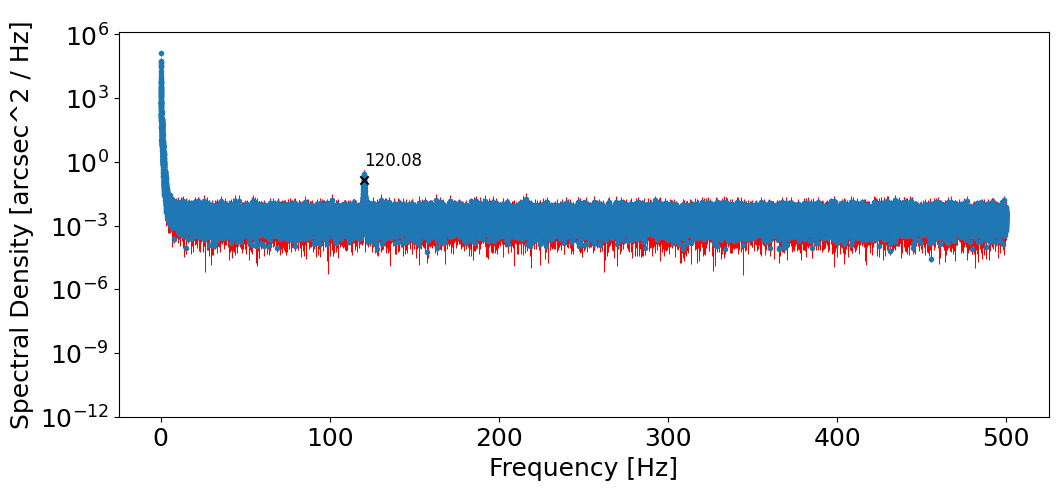

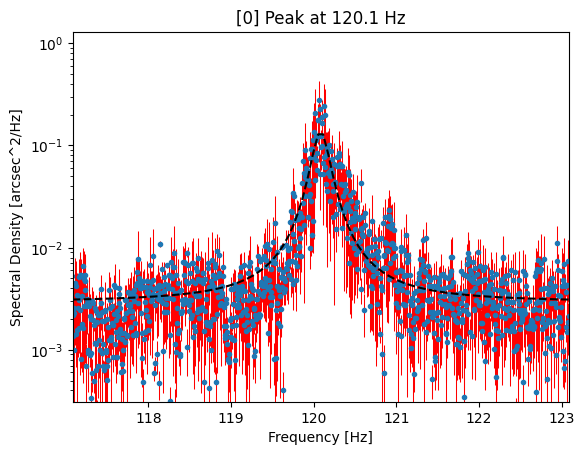

In [38]:
x_peaks = [16]
bearingon_adcselectronicson_real_xpeaks = keep_peaks_from(x_peaks, bearingon_adcselectronicson_x_peaks, 'Configuration_4_x.csv')
plot_peaks(bearingon_adcselectronicson_real_xpeaks, bearingon_adcselectronicson_freqs, bearingon_adcselectronicson_x_avgs,
           bearingon_adcselectronicson_x_SEM, ' ', 'x')

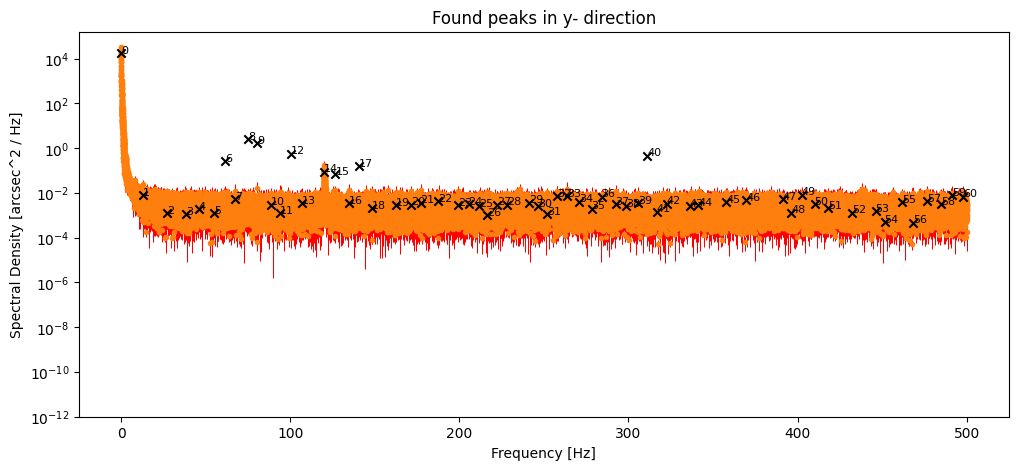

In [39]:
bearingon_adcselectronicson_y_peaks = do_science_with_offset(bearingon_adcselectronicson_freqs, bearingon_adcselectronicson_y_avgs, bearingon_adcselectronicson_y_SEM, True, 'y', 1e-3, 1e-3)

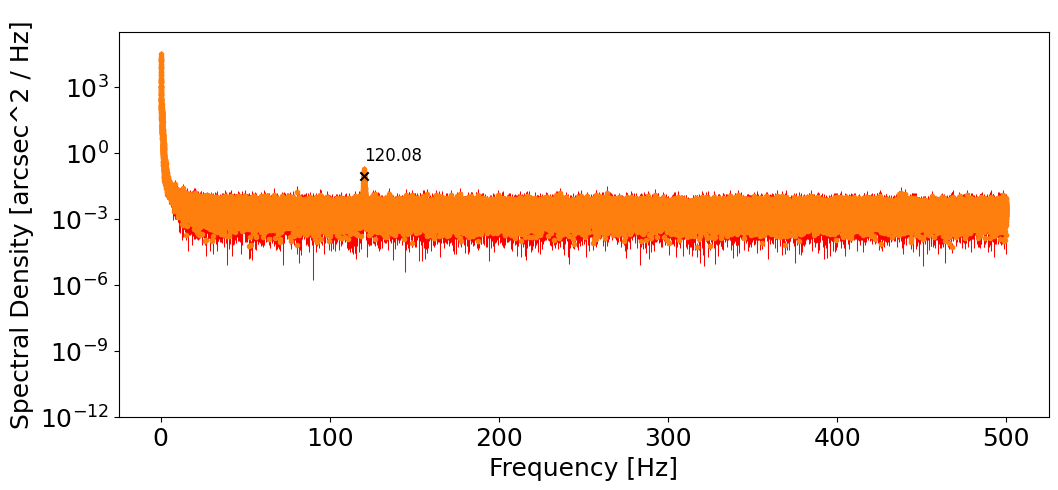

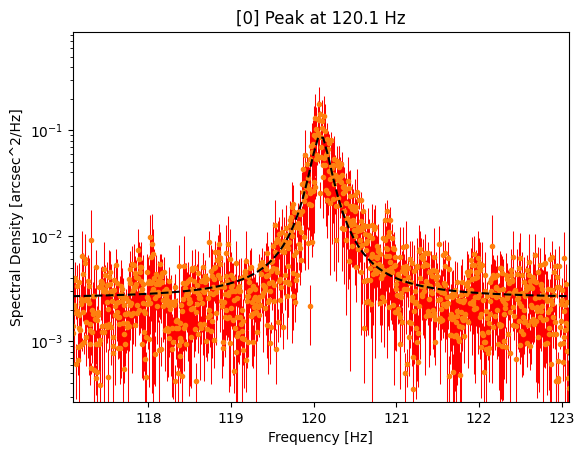

In [40]:
y_peaks = [14]
bearingon_adcselectronicson_real_ypeaks = keep_peaks_from(y_peaks, bearingon_adcselectronicson_y_peaks, 'Configuration_4_y.csv')
plot_peaks(bearingon_adcselectronicson_real_ypeaks, bearingon_adcselectronicson_freqs, bearingon_adcselectronicson_y_avgs,
           bearingon_adcselectronicson_y_SEM, ' ', 'y')

# Configuration 5

This configuration has the air bearing on, the bus and ADCS electronics on and the x direction reaction wheels on at 3000 RPM.

In [18]:
bearingon_adcsx_1 = np.genfromtxt('data_3_13_bearingon_adcsx_1in_20230313-181355.csv', delimiter = ',', skip_header = 2)
bearingon_adcsx_1_xdata, bearingon_adcsx_1_ydata, bearingon_adcsx_1_vsum, bearingon_adcsx_1_tdata = seperate_data_from(bearingon_adcsx_1)
bearingon_adcsx_1_xdisp = rad_to_arcsec(((bearingon_adcsx_1_xdata) - np.mean(bearingon_adcsx_1_xdata)) / throw_distance)
bearingon_adcsx_1_ydisp = rad_to_arcsec(((bearingon_adcsx_1_ydata) - np.mean(bearingon_adcsx_1_ydata)) / throw_distance)
bearingon_adcsx_1_xpsc_arcsec = power_spectrum(bearingon_adcsx_1_tdata, bearingon_adcsx_1_xdisp)
bearingon_adcsx_1_ypsc_arcsec = power_spectrum(bearingon_adcsx_1_tdata, bearingon_adcsx_1_ydisp)

bearingon_adcsx_2 = np.genfromtxt('data_3_13_bearingon_adcsx_2in_20230313-181917.csv', delimiter = ',', skip_header = 2)
bearingon_adcsx_2_xdata, bearingon_adcsx_2_ydata, bearingon_adcsx_2_vsum, bearingon_adcsx_2_tdata = seperate_data_from(bearingon_adcsx_2)
bearingon_adcsx_2_xdisp = rad_to_arcsec(((bearingon_adcsx_2_xdata) - np.mean(bearingon_adcsx_2_xdata)) / throw_distance)
bearingon_adcsx_2_ydisp = rad_to_arcsec(((bearingon_adcsx_2_ydata) - np.mean(bearingon_adcsx_2_ydata)) / throw_distance)
bearingon_adcsx_2_xpsc_arcsec = power_spectrum(bearingon_adcsx_2_tdata, bearingon_adcsx_2_xdisp)
bearingon_adcsx_2_ypsc_arcsec = power_spectrum(bearingon_adcsx_2_tdata, bearingon_adcsx_2_ydisp)

bearingon_adcsx_3 = np.genfromtxt('data_3_13_bearingon_adcsx_3in_20230313-182254.csv', delimiter = ',', skip_header = 2)
bearingon_adcsx_3_xdata, bearingon_adcsx_3_ydata, bearingon_adcsx_3_vsum, bearingon_adcsx_3_tdata = seperate_data_from(bearingon_adcsx_3)
bearingon_adcsx_3_xdisp = rad_to_arcsec(((bearingon_adcsx_3_xdata) - np.mean(bearingon_adcsx_3_xdata)) / throw_distance)
bearingon_adcsx_3_ydisp = rad_to_arcsec(((bearingon_adcsx_3_ydata) - np.mean(bearingon_adcsx_3_ydata)) / throw_distance)
bearingon_adcsx_3_xpsc_arcsec = power_spectrum(bearingon_adcsx_3_tdata, bearingon_adcsx_3_xdisp)
bearingon_adcsx_3_ypsc_arcsec = power_spectrum(bearingon_adcsx_3_tdata, bearingon_adcsx_3_ydisp)

In [19]:
#average out all the psd plots
bearingon_adcsx_x_psds = pd.DataFrame([bearingon_adcsx_1_xpsc_arcsec[1], bearingon_adcsx_2_xpsc_arcsec[1], bearingon_adcsx_3_xpsc_arcsec[1]])
bearingon_adcsx_y_psds = pd.DataFrame([bearingon_adcsx_1_ypsc_arcsec[1], bearingon_adcsx_2_ypsc_arcsec[1], bearingon_adcsx_3_ypsc_arcsec[1]])

#get the frequency divisions from any one of the psd plots a robust test would check all combinations, but I'm going to assume pcking two randomly shall suffice.
if np.array_equiv(bearingon_adcsx_1_xpsc_arcsec[0], bearingon_adcsx_3_ypsc_arcsec[0]):
  bearingon_adcsx_freqs = data_as_df(bearingon_adcsx_1_xpsc_arcsec[0])
else:
  raise Exception("Frequency binning does not match")

In [20]:
bearingon_adcsx_x_avgs = bearingon_adcsx_x_psds.mean(axis = 0)
bearingon_adcsx_x_SEM = bearingon_adcsx_x_psds.sem(axis = 0)
bearingon_adcsx_y_avgs = bearingon_adcsx_y_psds.mean(axis = 0)
bearingon_adcsx_y_SEM = bearingon_adcsx_y_psds.sem(axis =  0)

# Convert to df
bearingon_adcsx_x_avgs_df = data_as_df(bearingon_adcsx_x_avgs)
bearingon_adcsx_y_avgs_df = data_as_df(bearingon_adcsx_y_avgs)
bearingon_adcsx_freqs_df = data_as_df(bearingon_adcsx_freqs)

In [21]:
bearingon_adcsx_x_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcsx_x_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcsx_freqs_df.iloc[25020:]).flatten()))
bearingon_adcsx_y_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcsx_y_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcsx_freqs_df.iloc[25020:]).flatten()))

# Add the variances together
bearing_on_adcsx_var= bearingon_adcsx_x_var + bearingon_adcsx_y_var

# Compute the 1, 2 and 3 sigma pointing errors
np.sqrt(bearing_on_adcsx_var), 2*np.sqrt(bearing_on_adcsx_var), 3*np.sqrt(bearing_on_adcsx_var)

(0.5956279637597306, 1.1912559275194612, 1.7868838912791918)

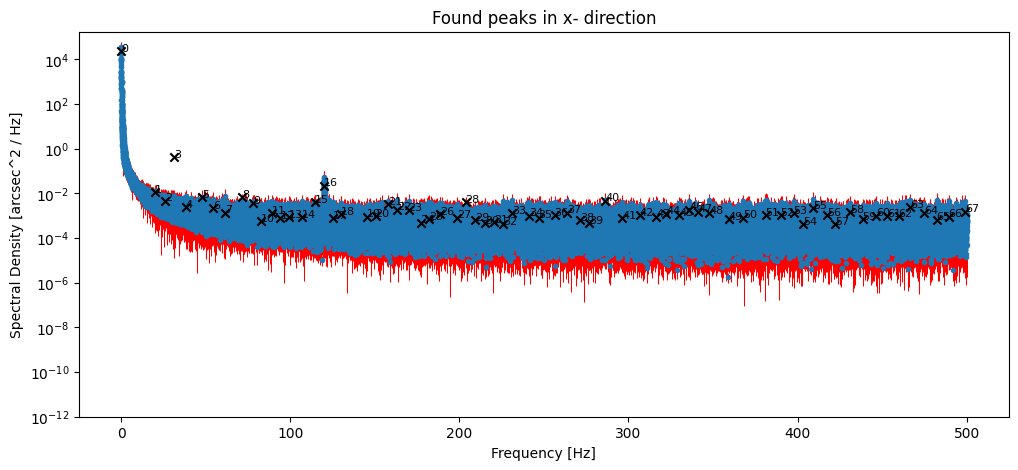

In [22]:
bearingon_adcsx_x_peaks = do_science_with_offset(bearingon_adcsx_freqs, bearingon_adcsx_x_avgs, bearingon_adcsx_x_SEM, True, 'x', 1e-3, 1e-3)

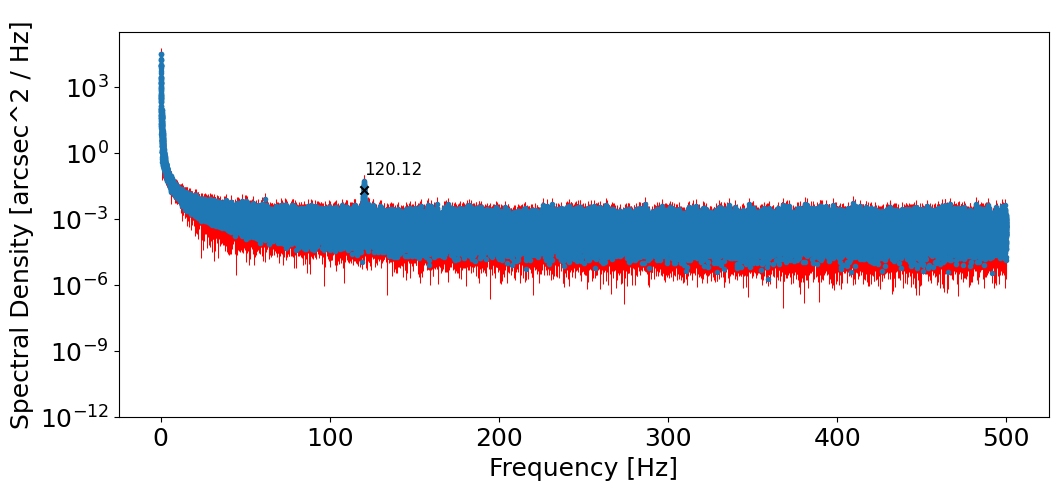

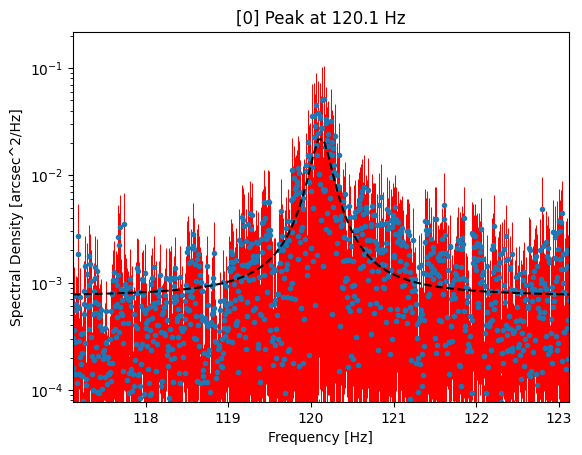

In [24]:
x_peaks = [16]
bearingon_adcsx_real_xpeaks = keep_peaks_from(x_peaks, bearingon_adcsx_x_peaks, 'Configuration_5_x.csv')
plot_peaks(bearingon_adcsx_real_xpeaks, bearingon_adcsx_freqs, bearingon_adcsx_x_avgs,
           bearingon_adcsx_x_SEM, ' ', 'x')

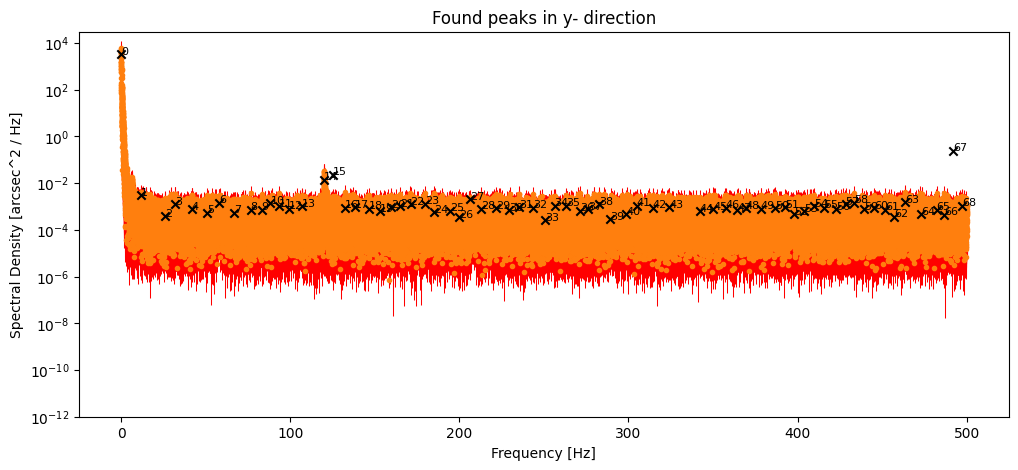

In [25]:
bearingon_adcsx_y_peaks = do_science_with_offset(bearingon_adcsx_freqs, bearingon_adcsx_y_avgs, bearingon_adcsx_y_SEM, True, 'y',1e-4, 1e-4)

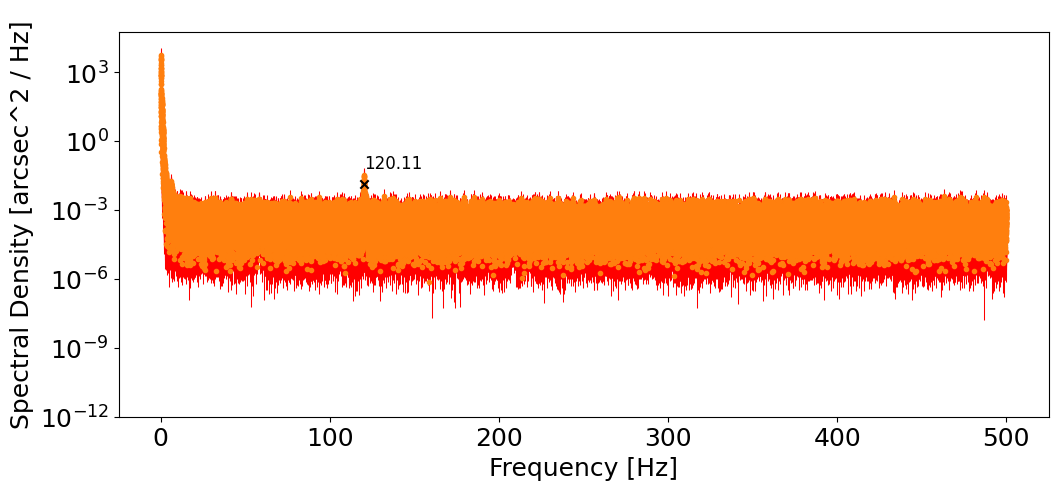

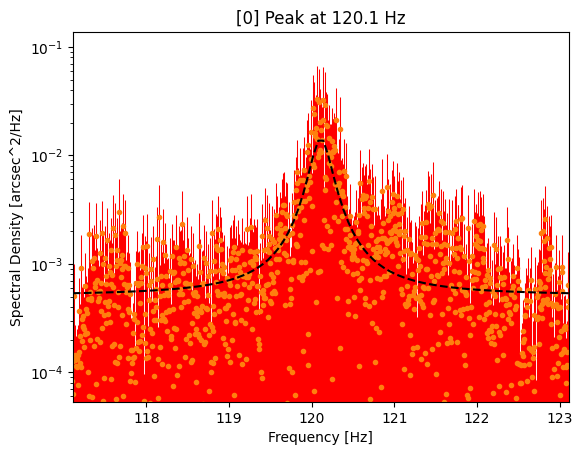

In [27]:
y_peaks = [14]
bearingon_adcsx_real_ypeaks = keep_peaks_from(y_peaks, bearingon_adcsx_y_peaks, 'Configuration_5_y.csv')
plot_peaks(bearingon_adcsx_real_ypeaks, bearingon_adcsx_freqs, bearingon_adcsx_y_avgs,
           bearingon_adcsx_y_SEM, ' ', 'y')

# Configuration 6

This configuration has the air bearing on, the satellite bus electronics and ADCS electronics on, the cryocooler/camera off, and the z-direction reaction wheel spinning at 3000 RPM.

In [28]:
# Data from the first run was bad - starting at 2
bearingon_adcsz_2 = np.genfromtxt('data_3_13_bearingon_adcsz_2in_20230313-183112.csv', delimiter = ',', skip_header = 2)
bearingon_adcsz_2_xdata, bearingon_adcsz_2_ydata, bearingon_adcsz_2_vsum, bearingon_adcsz_2_tdata = seperate_data_from(bearingon_adcsz_2)
bearingon_adcsz_2_xdisp = rad_to_arcsec(((bearingon_adcsz_2_xdata) - np.mean(bearingon_adcsz_2_xdata)) / throw_distance)
bearingon_adcsz_2_ydisp = rad_to_arcsec(((bearingon_adcsz_2_ydata) - np.mean(bearingon_adcsz_2_ydata)) / throw_distance)
bearingon_adcsz_2_xpsc_arcsec = power_spectrum(bearingon_adcsz_2_tdata, bearingon_adcsz_2_xdisp)
bearingon_adcsz_2_ypsc_arcsec = power_spectrum(bearingon_adcsz_2_tdata, bearingon_adcsz_2_ydisp)

# Read in data from the second trial
bearingon_adcsz_3 = np.genfromtxt('data_3_13_bearingon_adcsz_3in_20230313-183503.csv', delimiter = ',', skip_header = 2)
bearingon_adcsz_3_xdata, bearingon_adcsz_3_ydata, bearingon_adcsz_3_vsum, bearingon_adcsz_3_tdata = seperate_data_from(bearingon_adcsz_3)
bearingon_adcsz_3_xdisp = rad_to_arcsec(((bearingon_adcsz_3_xdata) - np.mean(bearingon_adcsz_3_xdata)) / throw_distance)
bearingon_adcsz_3_ydisp = rad_to_arcsec(((bearingon_adcsz_3_ydata) - np.mean(bearingon_adcsz_3_ydata)) / throw_distance)
bearingon_adcsz_3_xpsc_arcsec = power_spectrum(bearingon_adcsz_3_tdata, bearingon_adcsz_3_xdisp)
bearingon_adcsz_3_ypsc_arcsec = power_spectrum(bearingon_adcsz_3_tdata, bearingon_adcsz_3_ydisp)

# Read in data from the third trial
bearingon_adcsz_4 = np.genfromtxt('data_3_13_bearingon_adcsz_4in_20230313-183826.csv', delimiter = ',', skip_header = 2)
bearingon_adcsz_4_xdata, bearingon_adcsz_4_ydata, bearingon_adcsz_4_vsum, bearingon_adcsz_4_tdata = seperate_data_from(bearingon_adcsz_4)
bearingon_adcsz_4_xdisp = rad_to_arcsec(((bearingon_adcsz_4_xdata) - np.mean(bearingon_adcsz_4_xdata)) / throw_distance)
bearingon_adcsz_4_ydisp = rad_to_arcsec(((bearingon_adcsz_4_ydata) - np.mean(bearingon_adcsz_4_ydata)) / throw_distance)
bearingon_adcsz_4_xpsc_arcsec = power_spectrum(bearingon_adcsz_4_tdata, bearingon_adcsz_4_xdisp)
bearingon_adcsz_4_ypsc_arcsec = power_spectrum(bearingon_adcsz_4_tdata, bearingon_adcsz_4_ydisp)

In [29]:
# Concat the power sepctra
bearingon_adcsz_x_psds = pd.DataFrame([bearingon_adcsz_2_xpsc_arcsec[1], bearingon_adcsz_3_xpsc_arcsec[1], bearingon_adcsz_4_xpsc_arcsec[1]])
bearingon_adcsz_y_psds = pd.DataFrame([bearingon_adcsz_2_ypsc_arcsec[1], bearingon_adcsz_3_ypsc_arcsec[1], bearingon_adcsz_4_ypsc_arcsec[1]])

#get the frequency divisions from any one of the psd plots a robust test would check all combinations, but I'm going to assume pcking two randomly shall suffice.
if np.array_equiv(bearingon_adcsz_2_xpsc_arcsec[0], bearingon_adcsz_3_ypsc_arcsec[0]):
  bearingon_adcsz_freqs = data_as_df(bearingon_adcsz_2_xpsc_arcsec[0])
else:
  raise Exception("Frequency binning does not match")

In [30]:
bearingon_adcsz_x_avgs = bearingon_adcsz_x_psds.mean(axis = 0)
bearingon_adcsz_x_SEM = bearingon_adcsz_x_psds.sem(axis = 0)
bearingon_adcsz_y_avgs = bearingon_adcsz_y_psds.mean(axis = 0)
bearingon_adcsz_y_SEM = bearingon_adcsz_y_psds.sem(axis =  0)

bearingon_adcsz_x_avgs_df = data_as_df(bearingon_adcsz_x_avgs)
bearingon_adcsz_y_avgs_df = data_as_df(bearingon_adcsz_y_avgs)
bearingon_adcsz_freqs_df = data_as_df(bearingon_adcsz_freqs)

In [32]:
bearingon_adcsz_x_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcsz_x_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcsz_freqs_df.iloc[25020:]).flatten()))
bearingon_adcsz_y_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcsz_y_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcsz_freqs_df.iloc[25020:]).flatten()))

bearingon_adcsz_var = bearingon_adcsz_x_var + bearingon_adcsz_y_var

np.sqrt(bearingon_adcsz_var), 2*np.sqrt(bearingon_adcsz_var), 3*np.sqrt(bearingon_adcsz_var)

(0.1452560963273113, 0.2905121926546226, 0.43576828898193387)

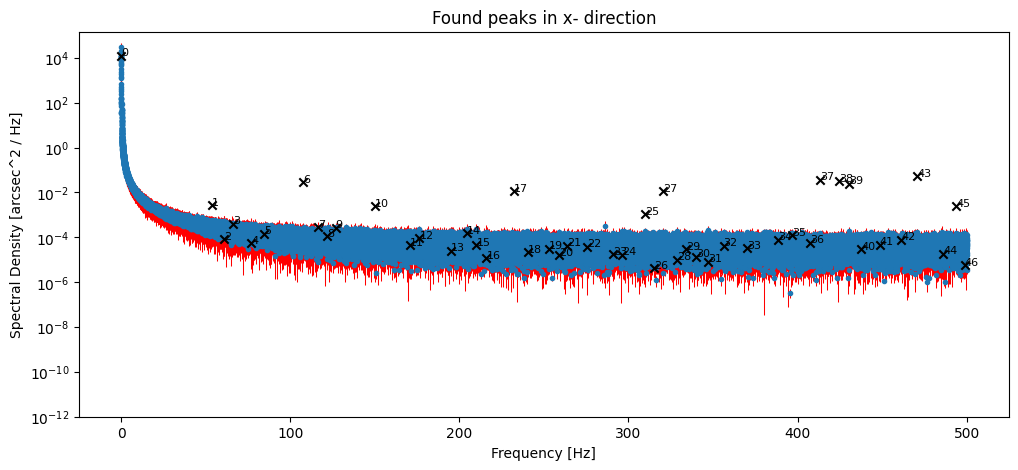

In [33]:
bearingon_adcsz_x_peaks = do_science_with_offset(bearingon_adcsz_freqs, bearingon_adcsz_x_avgs, bearingon_adcsz_x_SEM, True, 'x', 1e-5, 1e-5)

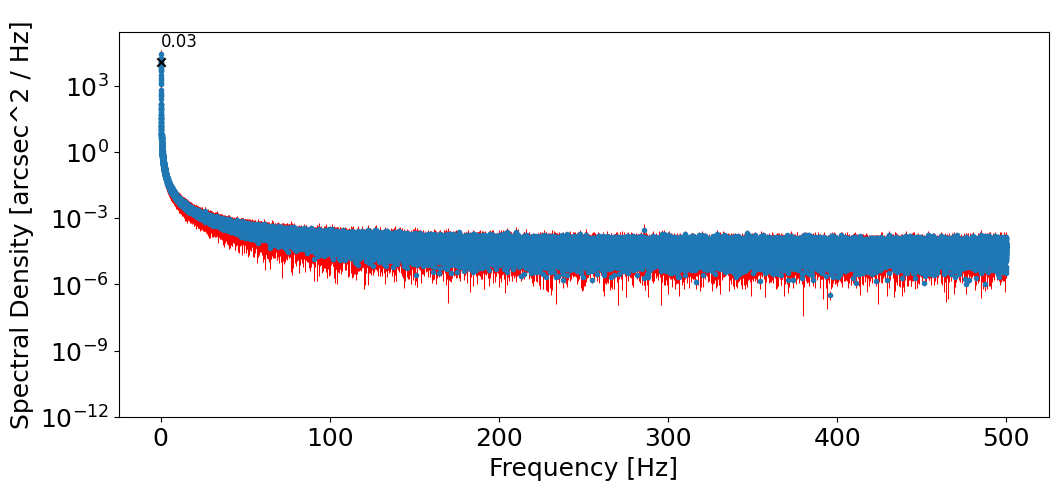

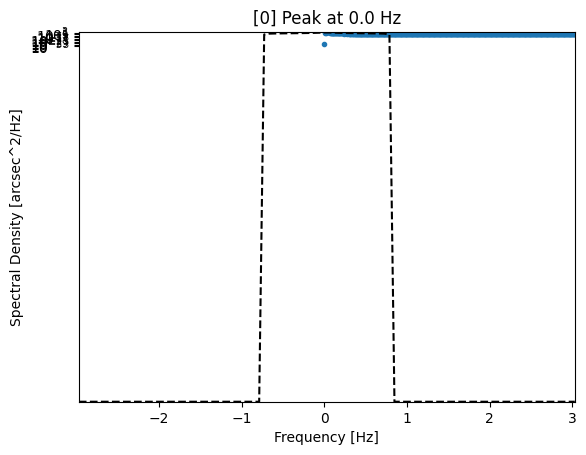

In [34]:
x_peaks = [0]
bearingon_adcsz_real_xpeaks = keep_peaks_from(x_peaks, bearingon_adcsz_x_peaks, 'Configuration_6_x.csv')
plot_peaks(bearingon_adcsz_real_xpeaks, bearingon_adcsz_freqs, bearingon_adcsz_x_avgs,
           bearingon_adcsz_x_SEM, ' ', 'x')

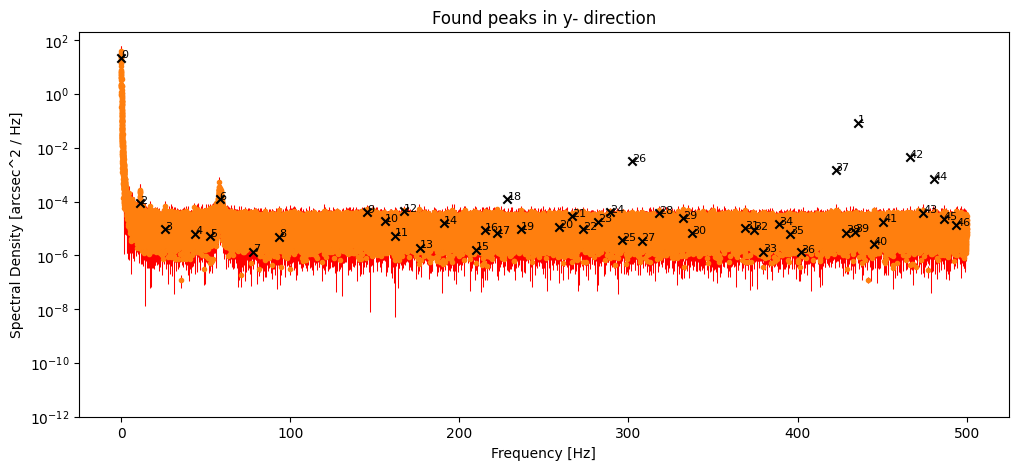

In [35]:
bearingon_adcsz_y_peaks = do_science_with_offset(bearingon_adcsz_freqs, bearingon_adcsz_y_avgs, bearingon_adcsz_y_SEM, True, 'y', 1e-5, 1e-5)

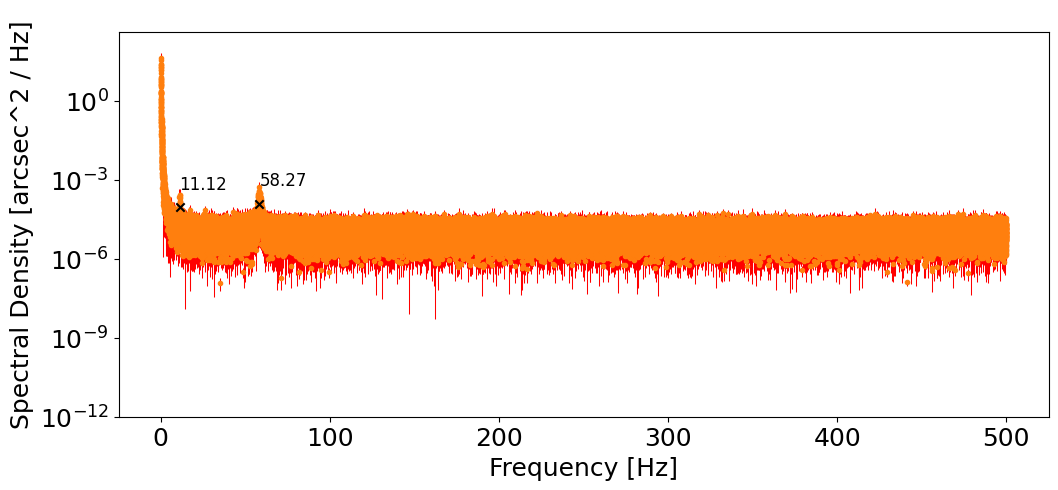

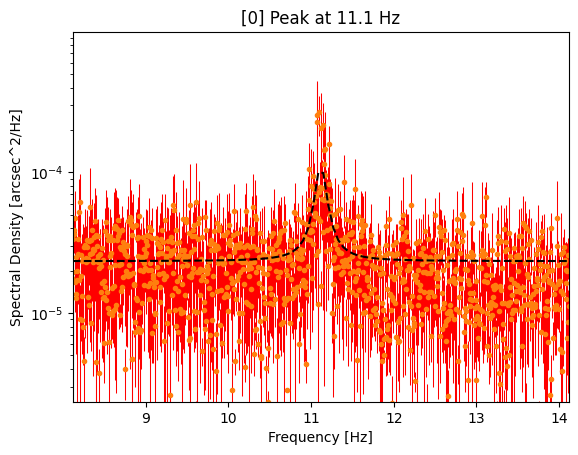

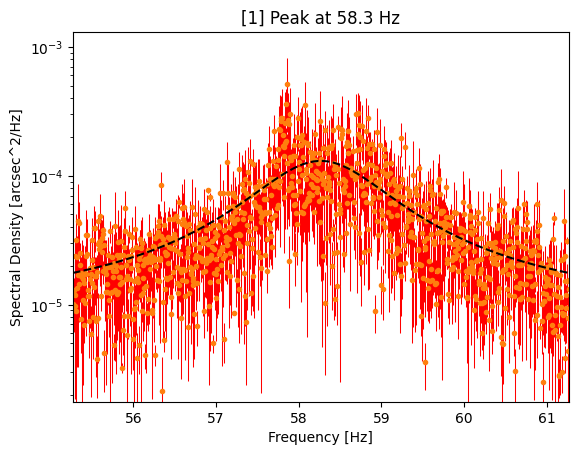

In [36]:
y_peaks = [2,6]
bearingon_adcsz_real_ypeaks = keep_peaks_from(y_peaks, bearingon_adcsz_y_peaks, 'Configuration_6_y.csv')
plot_peaks(bearingon_adcsz_real_ypeaks, bearingon_adcsz_freqs, bearingon_adcsz_y_avgs,
           bearingon_adcsz_y_SEM, ' ', 'y')

# Configuration 7

This configuration has the air bearing on, the satellite bus and ADCS electronics, the payload off, and the ADCS reaction wheels were on in both the x and y poistion

In [37]:
bearingon_adcsxz_1 = np.genfromtxt('data_3_13_bearingon_adcsxz_1in_20230313-184653.csv', delimiter = ',', skip_header = 2)
bearingon_adcsxz_1_xdata, bearingon_adcsxz_1_ydata, bearingon_adcsxz_1_vsum, bearingon_adcsxz_1_tdata = seperate_data_from(bearingon_adcsxz_1)
bearingon_adcsxz_1_xdisp = rad_to_arcsec(((bearingon_adcsxz_1_xdata) - np.mean(bearingon_adcsxz_1_xdata)) / throw_distance)
bearingon_adcsxz_1_ydisp = rad_to_arcsec(((bearingon_adcsxz_1_ydata) - np.mean(bearingon_adcsxz_1_ydata)) / throw_distance)
bearingon_adcsxz_1_xpsc_arcsec = power_spectrum(bearingon_adcsxz_1_tdata, bearingon_adcsxz_1_xdisp)
bearingon_adcsxz_1_ypsc_arcsec = power_spectrum(bearingon_adcsxz_1_tdata, bearingon_adcsxz_1_ydisp)

bearingon_adcsxz_2 = np.genfromtxt('data_3_13_bearingon_adcsxz_2in_20230313-185019.csv', delimiter = ',', skip_header = 2)
bearingon_adcsxz_2_xdata, bearingon_adcsxz_2_ydata, bearingon_adcsxz_2_vsum, bearingon_adcsxz_2_tdata = seperate_data_from(bearingon_adcsxz_2)
bearingon_adcsxz_2_xdisp = rad_to_arcsec(((bearingon_adcsxz_2_xdata) - np.mean(bearingon_adcsxz_2_xdata)) / throw_distance)
bearingon_adcsxz_2_ydisp = rad_to_arcsec(((bearingon_adcsxz_2_ydata) - np.mean(bearingon_adcsxz_2_ydata)) / throw_distance)
bearingon_adcsxz_2_xpsc_arcsec = power_spectrum(bearingon_adcsxz_2_tdata, bearingon_adcsxz_2_xdisp)
bearingon_adcsxz_2_ypsc_arcsec = power_spectrum(bearingon_adcsxz_2_tdata, bearingon_adcsxz_2_ydisp)

bearingon_adcsxz_3 = np.genfromtxt('data_3_13_bearingon_adcsxz_3in_20230313-185340.csv', delimiter = ',', skip_header = 2)
bearingon_adcsxz_3_xdata, bearingon_adcsxz_3_ydata, bearingon_adcsxz_3_vsum, bearingon_adcsxz_3_tdata = seperate_data_from(bearingon_adcsxz_3)
bearingon_adcsxz_3_xdisp = rad_to_arcsec(((bearingon_adcsxz_3_xdata) - np.mean(bearingon_adcsxz_3_xdata)) / throw_distance)
bearingon_adcsxz_3_ydisp = rad_to_arcsec(((bearingon_adcsxz_3_ydata) - np.mean(bearingon_adcsxz_3_ydata)) / throw_distance)
bearingon_adcsxz_3_xpsc_arcsec = power_spectrum(bearingon_adcsxz_3_tdata, bearingon_adcsxz_3_xdisp)
bearingon_adcsxz_3_ypsc_arcsec = power_spectrum(bearingon_adcsxz_3_tdata, bearingon_adcsxz_3_ydisp)

bearingon_adcsxz_4 = np.genfromtxt('data_3_13_bearingon_adcsxz_4in_20230313-185754.csv', delimiter = ',', skip_header = 2)
bearingon_adcsxz_4_xdata, bearingon_adcsxz_4_ydata, bearingon_adcsxz_4_vsum, bearingon_adcsxz_4_tdata = seperate_data_from(bearingon_adcsxz_4)
bearingon_adcsxz_4_xdisp = rad_to_arcsec(((bearingon_adcsxz_4_xdata) - np.mean(bearingon_adcsxz_4_xdata)) / throw_distance)
bearingon_adcsxz_4_ydisp = rad_to_arcsec(((bearingon_adcsxz_4_ydata) - np.mean(bearingon_adcsxz_4_ydata)) / throw_distance)
bearingon_adcsxz_4_xpsc_arcsec = power_spectrum(bearingon_adcsxz_4_tdata, bearingon_adcsxz_4_xdisp)
bearingon_adcsxz_4_ypsc_arcsec = power_spectrum(bearingon_adcsxz_4_tdata, bearingon_adcsxz_4_ydisp)

In [38]:
 #average out all the psd plots
bearingon_adcsxz_x_psds = pd.DataFrame([bearingon_adcsxz_1_xpsc_arcsec[1], bearingon_adcsxz_2_xpsc_arcsec[1],
                                        bearingon_adcsxz_3_xpsc_arcsec[1], bearingon_adcsxz_4_xpsc_arcsec[1]])

bearingon_adcsxz_y_psds = pd.DataFrame([bearingon_adcsxz_1_ypsc_arcsec[1], bearingon_adcsxz_2_ypsc_arcsec[1],
                                        bearingon_adcsxz_3_ypsc_arcsec[1], bearingon_adcsxz_4_ypsc_arcsec[1]])

#get the frequency divisions from any one of the psd plots a robust test would check all combinations, but I'm going to assume pcking two randomly shall suffice.
if np.array_equiv(bearingon_adcsxz_1_xpsc_arcsec[0], bearingon_adcsxz_4_ypsc_arcsec[0]):
  bearingon_adcsxz_freqs = data_as_df(bearingon_adcsxz_1_xpsc_arcsec[0])
else:
  raise Exception("Frequency binning does not match")

In [39]:
bearingon_adcsxz_x_avgs = bearingon_adcsxz_x_psds.mean(axis = 0)
bearingon_adcsxz_x_SEM = bearingon_adcsxz_x_psds.sem(axis = 0)
bearingon_adcsxz_y_avgs = bearingon_adcsxz_y_psds.mean(axis = 0)
bearingon_adcsxz_y_SEM = bearingon_adcsxz_y_psds.sem(axis =  0)

# Convert the arrays to df's
bearingon_adcsxz_x_avgs_df = data_as_df(bearingon_adcsxz_x_avgs)
bearingon_adcsxz_y_avgs_df = data_as_df(bearingon_adcsxz_y_avgs)
bearingon_adcsxz_freqs_df = data_as_df(bearingon_adcsxz_freqs)

In [40]:
bearingon_adcsxz_x_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcsxz_x_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcsxz_freqs_df.iloc[25020:]).flatten()))
bearingon_adcsxz_y_var = (scipy.integrate.trapezoid(np.asarray(bearingon_adcsxz_y_avgs_df.iloc[25020:]).flatten(),
                                                                np.asarray(bearingon_adcsxz_freqs_df.iloc[25020:]).flatten()))

bearingon_adcsxz_var = bearingon_adcsxz_x_var+ bearingon_adcsxz_y_var

np.sqrt(bearingon_adcsxz_var), 2*np.sqrt(bearingon_adcsxz_var), 3*np.sqrt(bearingon_adcsxz_var)

(0.14085523241634287, 0.28171046483268575, 0.4225656972490286)

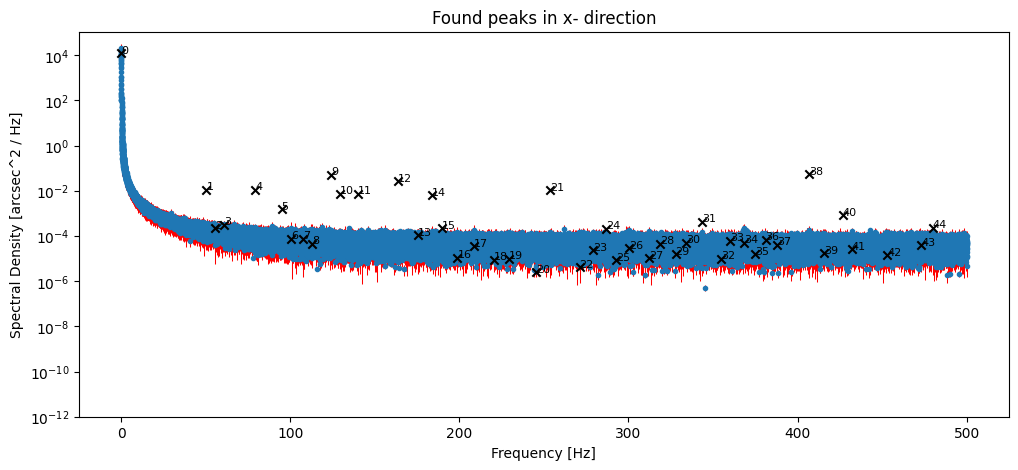

In [41]:
bearingon_adcsxz_x_peaks = do_science_with_offset(bearingon_adcsxz_freqs, bearingon_adcsxz_x_avgs, bearingon_adcsxz_x_SEM, True, 'x', 1e-5, 1e-5)

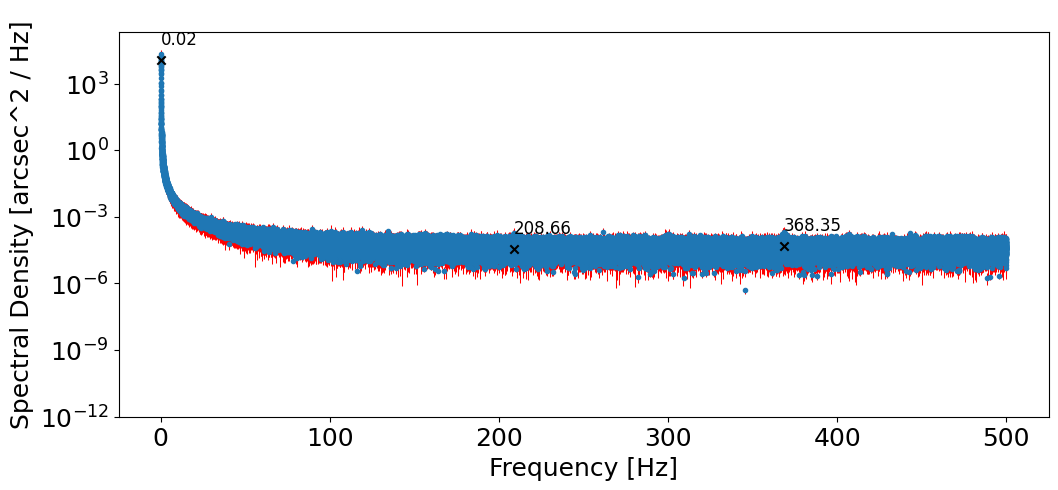

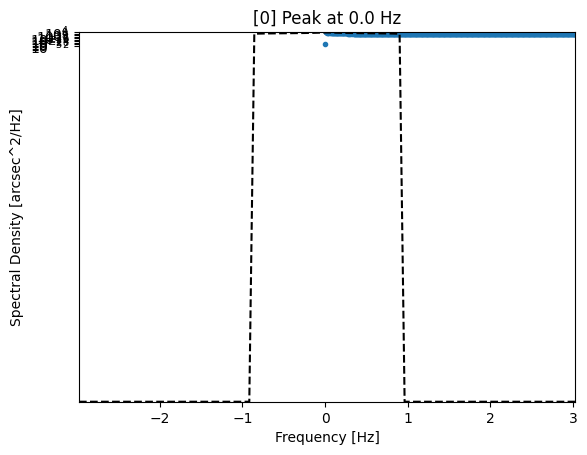

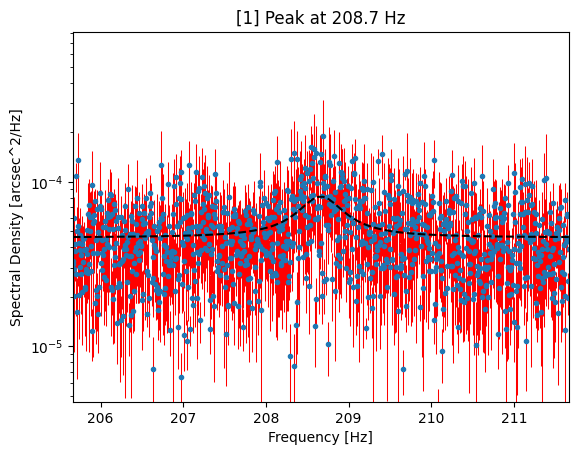

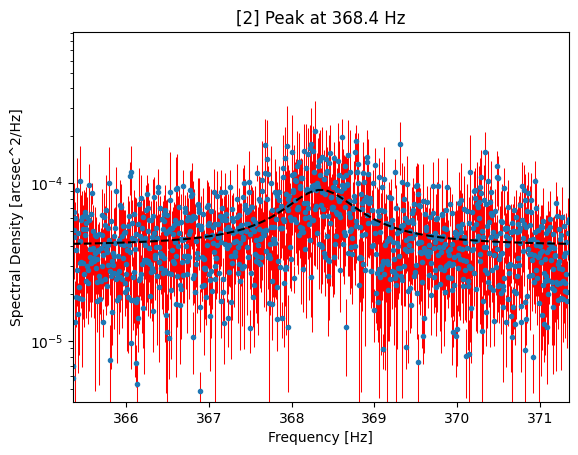

In [43]:
x_peaks = [0, 17, 34]
bearingon_adcsxz_real_xpeaks = keep_peaks_from(x_peaks, bearingon_adcsxz_x_peaks, 'Configuration_7_x.csv')
plot_peaks(bearingon_adcsxz_real_xpeaks, bearingon_adcsxz_freqs, bearingon_adcsxz_x_avgs,
           bearingon_adcsxz_x_SEM, ' ', 'x')

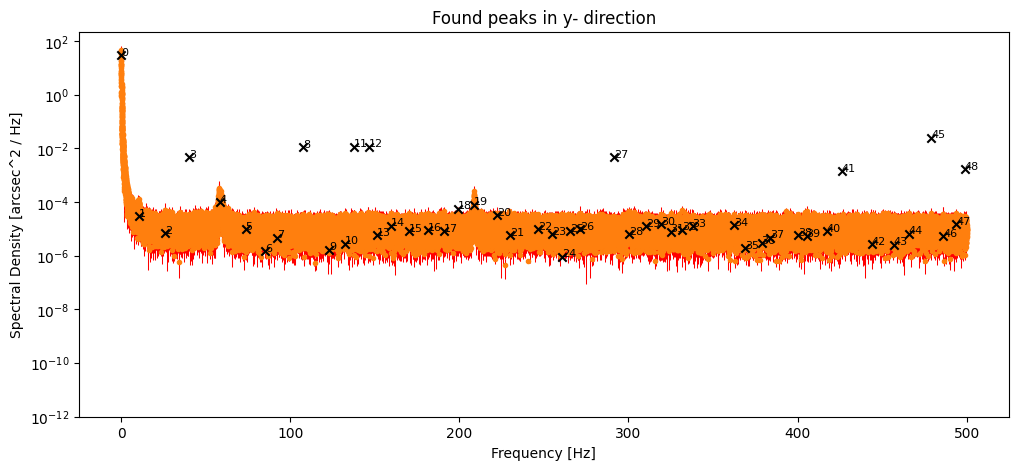

In [44]:
bearingon_adcsxz_y_peaks = do_science_with_offset(bearingon_adcsxz_freqs, bearingon_adcsxz_y_avgs, bearingon_adcsxz_y_SEM, True, 'y', 1e-5, 1e-6)

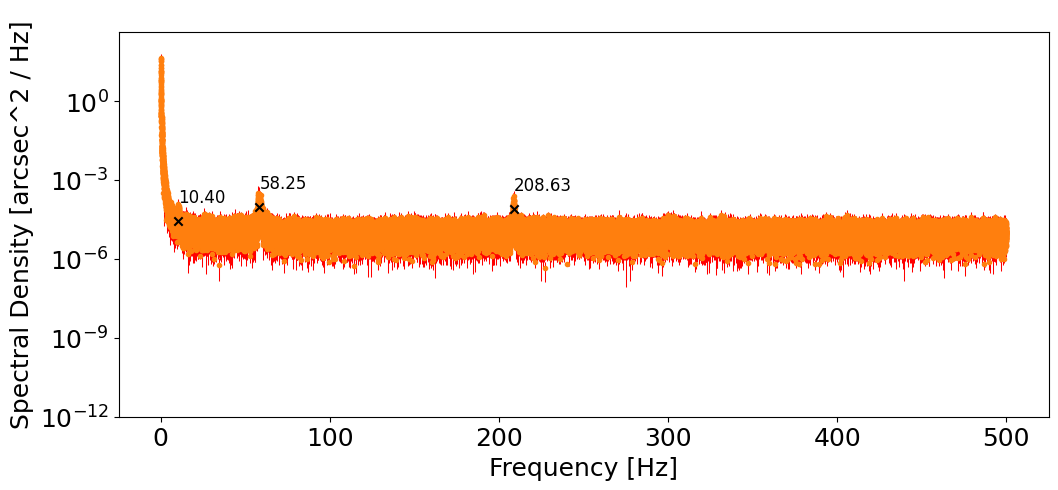

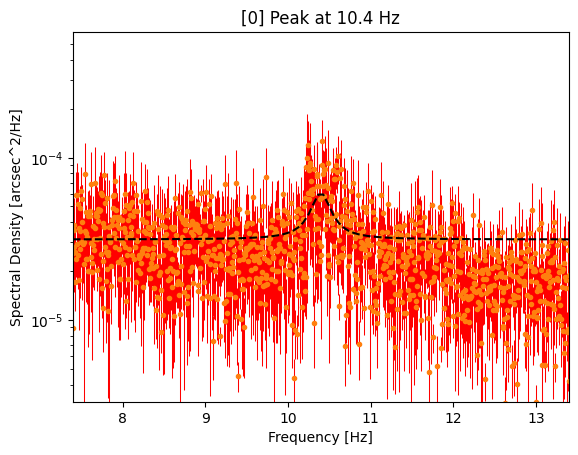

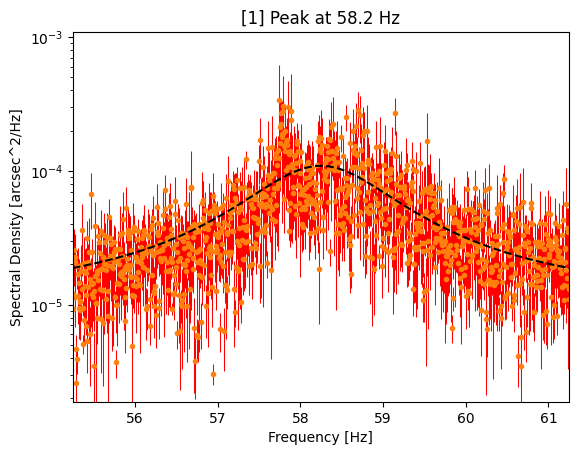

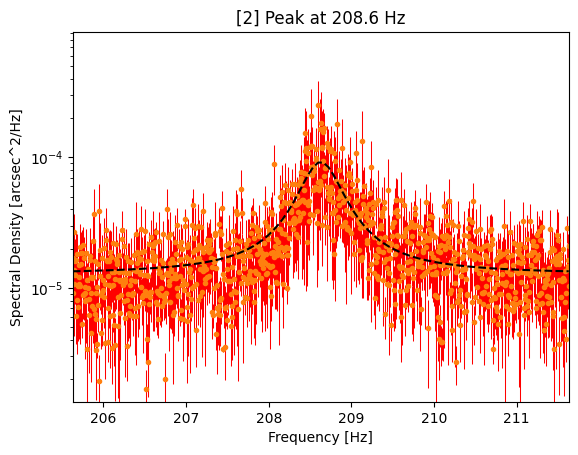

In [46]:
y_peaks = [1,4, 19]
bearingon_adcsxz_real_ypeaks = keep_peaks_from(y_peaks, bearingon_adcsxz_y_peaks, 'Configuration_7_y.csv')
plot_peaks(bearingon_adcsxz_real_ypeaks, bearingon_adcsxz_freqs, bearingon_adcsxz_y_avgs,
           bearingon_adcsxz_y_SEM, ' ', 'y')